In [1]:
import scvelo as scv
import numpy as np
import random
import torch
import scanpy as sc
from scvelo.preprocessing.moments import get_moments

import Myvelo.train
from Myvelo.train import train, Constants
from Myvelo._utils import update_dict, autoset_coeff_s
from Myvelo.data import preprocess_data

import TFvelo.TFvelo.preprocessing as TFpp

In [2]:
import sys
sys.modules['Myvelo.train']

<module 'Myvelo.train' from '/home/qukungroup/syuqiao22/intracurricular/BioSysModel/project/Myvelo/train.py'>

In [3]:
from importlib import reload
reload(sys.modules['Myvelo.train'])

<module 'Myvelo.train' from '/home/qukungroup/syuqiao22/intracurricular/BioSysModel/project/Myvelo/train.py'>

In [3]:
from Myvelo.train import train, Constants

In [41]:
import matplotlib.pyplot as plt

In [5]:
# adata_cap = adata.copy()
# adata_cap.var_names = [name.upper() for name in adata_cap.var_names]
# adata_cap

In [4]:
Constants.default_configs

{'name': 'InterVelo_project',
 'n_gpu': 1,
 'arch': {'type': 'InterVELO',
  'args': {'n_ode_hidden': 25,
   'n_hidden': 128,
   'n_latent': 20,
   'log_variational': False,
   'pred_unspliced': False,
   'use_batch_norm': False,
   'use_layer_norm': False,
   'ode_method': 'euler',
   'step_size': None,
   'alpha_recon_lec': 0.5,
   'alpha_recon_lode': 0.5,
   'loss1_scale': 1.0,
   'loss2_scale': 1.0,
   'l1reg_loss_scale': 0.001,
   'alpha_latent_loss_scale': 0.5,
   'dropout_rate': 0.1,
   'scale1': 1,
   'scale2': 1,
   'do_extend_TF': False}},
 'data_loader': {'type': 'VeloDataLoader',
  'args': {'batch_size': 1024,
   'shuffle': True,
   'validation_split': 0.1,
   'num_workers': 10,
   'velocity_genes': False,
   'use_scaled_u': False}},
 'optimizer': {'type': 'Adam',
  'args': {'lr': 0.01, 'weight_decay': 0.01, 'amsgrad': True, 'eps': 0.01}},
 'loss_pearson': {'coeff_u': 1.0, 'coeff_s': 1.0},
 'mask_zeros': False,
 'lr_scheduler': {'type': 'StepLR', 'args': {'step_size': 1, 'ga

In [213]:
#Setting appropriate initial values can help estimate pseudotime. 
#As the velocity direction is more stable than pseudotime, we suggest taking it as the references
#If the pseudotime is inconsistent with the velocity direction, try changing the random seed.
SEED = 123
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

adata = scv.datasets.pancreas()
# adata = adata.var[adata.var_names.]

adata.var_names = [name.upper() for name in adata.var_names]

scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
adata = preprocess_data(adata, layers=["Ms","Mu"], filter_on_r2=False)
#spliced = csr_matrix(adata.layers["spliced"]).astype(np.float32).A
spliced = torch.tensor(adata.layers["Ms"])
unspliced = torch.tensor(adata.layers["Mu"])
inputdata=torch.cat([spliced,unspliced],dim=1)

if "spliced" in adata.layers:
        adata.layers["total"] = adata.layers["spliced"].todense() + adata.layers["unspliced"].todense()
elif "new" in adata.layers:
    adata.layers["total"] = np.array(adata.layers["total"].todense())
else:
    adata.layers["total"] = adata.X
adata.layers["total_raw"] = adata.layers["total"].copy()
TFpp.moments(adata, n_pcs=30, n_neighbors=30)

configs = {
    "name": "InterVelo", # name of the experiment
    "loss_pearson": {"coeff_s": autoset_coeff_s(adata)}  ,# Automatic setting of the spliced correlation objective
    "arch": {"args": {
        "pred_unspliced": False,
        #"scale1":1,   # Changing the sign of scale1 can help control the direction of pseudotime.
        "alpha_latent_loss_scale": 0.0,
        'l1reg_loss_scale': 0.001,
        'loss1_scale': 0.1,
        'loss2_scale': 15.0,
        'gamma_loss_scale': 0.001,
        'n_hidden': 64,
        'do_extend_TF': True,
}},
    'trainer': {
        "epochs": 75,
    }
}
configs = update_dict(Constants.default_configs, configs)

import time

start_time = time.time()

trainer = train(
    adata, 
    inputdata, 
    configs, 
    TF_databases='ENCODE ChEA', 
    TFdata_path='Myvelo/', 
    return_kinetic_rates=True, 
    debug=True,
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Myvelo: {elapsed_time:.2f} seconds")

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Filtered out 0 genes according to linear regression fit.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'M_total', moments of total abundances (adata.layers)
The ratio of spliced reads is 83.2% (between 70% and 85%). Suggest using coeff_s 0.75.
pwd: /home/qukungroup/syuqiao22/intracurricular/BioSysModel/project
Get TFs according to ENCODE ChEA
/home/qukungroup/syuqiao22/intracurricular/BioSysModel/project
max_n_TF: 33
mean_n_TF: 15.957
gene num of 0 TF: 62
total num of TFs: 55
9 genes in TF list not included in adata
dict_keys(['ATF3', 'AUTS2', 'BCOR', 'CCND1', 'CHD7', 'CLOCK', 'CREB1', 'CREM', 'DACH1', 'E2F1', 'EBF1', 'EGR1', 'ELF5', 'ETV1', 'EZH2', '

INFO:train:Beginning training of InterVelo ...
INFO:trainer:    epoch          : 1
INFO:trainer:    time:          : 28.114797592163086
INFO:trainer:    loss           : 9473.459594726562
INFO:trainer:    val_loss       : 8724.7490234375
INFO:trainer:    epoch          : 2
INFO:trainer:    time:          : 28.75684905052185
INFO:trainer:    loss           : 9199.402954101562
INFO:trainer:    val_loss       : 8685.0654296875
INFO:trainer:    epoch          : 3
INFO:trainer:    time:          : 28.582836866378784
INFO:trainer:    loss           : 8335.5478515625
INFO:trainer:    val_loss       : 8149.2314453125
INFO:trainer:    epoch          : 4
INFO:trainer:    time:          : 29.24414563179016
INFO:trainer:    loss           : 6974.7301025390625
INFO:trainer:    val_loss       : 7212.46826171875


loss composition: 
 {'loss1': tensor(432.3785, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(2561.7651, grad_fn=<SumBackward0>), 'loss2': tensor(95.5888, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0253, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4940, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 5
INFO:trainer:    time:          : 27.93271493911743
INFO:trainer:    loss           : 6272.5234375
INFO:trainer:    val_loss       : 6223.9658203125
INFO:trainer:    epoch          : 6
INFO:trainer:    time:          : 28.264342784881592
INFO:trainer:    loss           : 6074.1236572265625
INFO:trainer:    val_loss       : 5637.7353515625
INFO:trainer:    epoch          : 7
INFO:trainer:    time:          : 29.189441204071045
INFO:trainer:    loss           : 5756.8905029296875
INFO:trainer:    val_loss       : 5659.32177734375
INFO:trainer:    epoch          : 8
INFO:trainer:    time:          : 28.221664428710938
INFO:trainer:    loss           : 5836.717529296875
INFO:trainer:    val_loss       : 5864.6396484375
INFO:trainer:    epoch          : 9
INFO:trainer:    time:          : 28.08551287651062
INFO:trainer:    loss           : 5624.9189453125
INFO:trainer:    val_loss       : 5529.15771484375


loss composition: 
 {'loss1': tensor(409.6685, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(2164.4307, grad_fn=<SumBackward0>), 'loss2': tensor(96.9577, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0244, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4947, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 10
INFO:trainer:    time:          : 28.174719095230103
INFO:trainer:    loss           : 5690.681884765625
INFO:trainer:    val_loss       : 5321.52734375
INFO:trainer:    epoch          : 11
INFO:trainer:    time:          : 27.078582525253296
INFO:trainer:    loss           : 5528.8868408203125
INFO:trainer:    val_loss       : 5185.685546875
INFO:trainer:    epoch          : 12
INFO:trainer:    time:          : 28.540238857269287
INFO:trainer:    loss           : 5452.6263427734375
INFO:trainer:    val_loss       : 5422.18994140625
INFO:trainer:    epoch          : 13
INFO:trainer:    time:          : 28.360687017440796
INFO:trainer:    loss           : 5359.745849609375
INFO:trainer:    val_loss       : 5232.70703125
INFO:trainer:    epoch          : 14
INFO:trainer:    time:          : 28.05365800857544
INFO:trainer:    loss           : 5439.967529296875
INFO:trainer:    val_loss       : 5136.58056640625


loss composition: 
 {'loss1': tensor(360.0815, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(1869.8772, grad_fn=<SumBackward0>), 'loss2': tensor(94.1660, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0094, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4886, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 15
INFO:trainer:    time:          : 28.646451234817505
INFO:trainer:    loss           : 5290.2919921875
INFO:trainer:    val_loss       : 5136.10693359375
INFO:trainer:    epoch          : 16
INFO:trainer:    time:          : 27.87859559059143
INFO:trainer:    loss           : 5253.57763671875
INFO:trainer:    val_loss       : 5215.1611328125
INFO:trainer:    epoch          : 17
INFO:trainer:    time:          : 27.413442611694336
INFO:trainer:    loss           : 5149.6593017578125
INFO:trainer:    val_loss       : 5120.060546875
INFO:trainer:    epoch          : 18
INFO:trainer:    time:          : 26.199240684509277
INFO:trainer:    loss           : 5133.348388671875
INFO:trainer:    val_loss       : 5028.02587890625
INFO:trainer:    epoch          : 19
INFO:trainer:    time:          : 25.360984086990356
INFO:trainer:    loss           : 5095.9107666015625
INFO:trainer:    val_loss       : 5026.1435546875


loss composition: 
 {'loss1': tensor(336.2387, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(1649.4375, grad_fn=<SumBackward0>), 'loss2': tensor(93.7444, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0066, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4850, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 20
INFO:trainer:    time:          : 25.280784368515015
INFO:trainer:    loss           : 5061.9222412109375
INFO:trainer:    val_loss       : 5063.08154296875
INFO:trainer:    epoch          : 21
INFO:trainer:    time:          : 24.949359893798828
INFO:trainer:    loss           : 5047.8902587890625
INFO:trainer:    val_loss       : 5055.34228515625
INFO:trainer:    epoch          : 22
INFO:trainer:    time:          : 25.63186025619507
INFO:trainer:    loss           : 5086.1448974609375
INFO:trainer:    val_loss       : 4879.68408203125
INFO:trainer:    epoch          : 23
INFO:trainer:    time:          : 25.91388702392578
INFO:trainer:    loss           : 4842.83056640625
INFO:trainer:    val_loss       : 4738.04345703125
INFO:trainer:    epoch          : 24
INFO:trainer:    time:          : 25.496581077575684
INFO:trainer:    loss           : 4910.4510498046875
INFO:trainer:    val_loss       : 4802.9990234375


loss composition: 
 {'loss1': tensor(320.9897, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(1481.4348, grad_fn=<SumBackward0>), 'loss2': tensor(99.5658, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0050, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4845, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 25
INFO:trainer:    time:          : 25.254507541656494
INFO:trainer:    loss           : 4841.3770751953125
INFO:trainer:    val_loss       : 5178.86376953125
INFO:trainer:    epoch          : 26
INFO:trainer:    time:          : 25.200665712356567
INFO:trainer:    loss           : 4770.0487060546875
INFO:trainer:    val_loss       : 4790.98583984375
INFO:trainer:    epoch          : 27
INFO:trainer:    time:          : 24.608779668807983
INFO:trainer:    loss           : 4833.3892822265625
INFO:trainer:    val_loss       : 4669.0048828125
INFO:trainer:    epoch          : 28
INFO:trainer:    time:          : 24.69245409965515
INFO:trainer:    loss           : 4726.1068115234375
INFO:trainer:    val_loss       : 4757.90185546875
INFO:trainer:    epoch          : 29
INFO:trainer:    time:          : 24.92024564743042
INFO:trainer:    loss           : 4795.090087890625
INFO:trainer:    val_loss       : 4732.1259765625


loss composition: 
 {'loss1': tensor(320.3350, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(1351.3552, grad_fn=<SumBackward0>), 'loss2': tensor(93.0804, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0045, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4832, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 30
INFO:trainer:    time:          : 27.883805513381958
INFO:trainer:    loss           : 4806.26611328125
INFO:trainer:    val_loss       : 4696.9404296875
INFO:trainer:    epoch          : 31
INFO:trainer:    time:          : 27.353824853897095
INFO:trainer:    loss           : 4816.091064453125
INFO:trainer:    val_loss       : 4839.5146484375
INFO:trainer:    epoch          : 32
INFO:trainer:    time:          : 27.131576538085938
INFO:trainer:    loss           : 4789.247314453125
INFO:trainer:    val_loss       : 4819.48779296875
INFO:trainer:    epoch          : 33
INFO:trainer:    time:          : 27.103418588638306
INFO:trainer:    loss           : 4843.522216796875
INFO:trainer:    val_loss       : 4816.73388671875
INFO:trainer:    epoch          : 34
INFO:trainer:    time:          : 27.171777725219727
INFO:trainer:    loss           : 4807.05908203125
INFO:trainer:    val_loss       : 4801.4462890625


loss composition: 
 {'loss1': tensor(318.4046, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(1249.4861, grad_fn=<SumBackward0>), 'loss2': tensor(96.7320, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0029, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4814, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 35
INFO:trainer:    time:          : 26.75162434577942
INFO:trainer:    loss           : 4732.8677978515625
INFO:trainer:    val_loss       : 4686.208984375
INFO:trainer:    epoch          : 36
INFO:trainer:    time:          : 25.623323440551758
INFO:trainer:    loss           : 4698.3563232421875
INFO:trainer:    val_loss       : 4733.97900390625
INFO:trainer:    epoch          : 37
INFO:trainer:    time:          : 25.017407655715942
INFO:trainer:    loss           : 4688.8017578125
INFO:trainer:    val_loss       : 4584.74560546875
INFO:trainer:    epoch          : 38
INFO:trainer:    time:          : 25.569813013076782
INFO:trainer:    loss           : 4681.62060546875
INFO:trainer:    val_loss       : 4629.71630859375
INFO:trainer:    epoch          : 39
INFO:trainer:    time:          : 24.507946252822876
INFO:trainer:    loss           : 4578.451904296875
INFO:trainer:    val_loss       : 4541.359375


loss composition: 
 {'loss1': tensor(298.1783, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(1168.3369, grad_fn=<SumBackward0>), 'loss2': tensor(96.1705, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0013, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4817, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 40
INFO:trainer:    time:          : 24.61487102508545
INFO:trainer:    loss           : 4560.5531005859375
INFO:trainer:    val_loss       : 4801.96044921875
INFO:trainer:    epoch          : 41
INFO:trainer:    time:          : 23.310105562210083
INFO:trainer:    loss           : 4514.9727783203125
INFO:trainer:    val_loss       : 4618.67578125
INFO:trainer:    epoch          : 42
INFO:trainer:    time:          : 23.051599979400635
INFO:trainer:    loss           : 4597.508544921875
INFO:trainer:    val_loss       : 4497.30859375
INFO:trainer:    epoch          : 43
INFO:trainer:    time:          : 24.96678376197815
INFO:trainer:    loss           : 4546.5408935546875
INFO:trainer:    val_loss       : 4568.11962890625
INFO:trainer:    epoch          : 44
INFO:trainer:    time:          : 25.13093376159668
INFO:trainer:    loss           : 4614.2392578125
INFO:trainer:    val_loss       : 4655.76806640625


loss composition: 
 {'loss1': tensor(305.5178, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(1102.7966, grad_fn=<SumBackward0>), 'loss2': tensor(99.4183, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0017, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4821, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 45
INFO:trainer:    time:          : 24.827006101608276
INFO:trainer:    loss           : 4669.0755615234375
INFO:trainer:    val_loss       : 4710.22802734375
INFO:trainer:    epoch          : 46
INFO:trainer:    time:          : 25.396604299545288
INFO:trainer:    loss           : 4621.0419921875
INFO:trainer:    val_loss       : 4683.8154296875
INFO:trainer:    epoch          : 47
INFO:trainer:    time:          : 25.436788320541382
INFO:trainer:    loss           : 4607.1060791015625
INFO:trainer:    val_loss       : 4654.81298828125
INFO:trainer:    epoch          : 48
INFO:trainer:    time:          : 24.937827348709106
INFO:trainer:    loss           : 4691.633544921875
INFO:trainer:    val_loss       : 4760.66064453125
INFO:trainer:    epoch          : 49
INFO:trainer:    time:          : 26.330194234848022
INFO:trainer:    loss           : 4704.491943359375
INFO:trainer:    val_loss       : 4681.80322265625


loss composition: 
 {'loss1': tensor(308.1030, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(1049.4032, grad_fn=<SumBackward0>), 'loss2': tensor(93.3321, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0015, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4817, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 50
INFO:trainer:    time:          : 25.17555260658264
INFO:trainer:    loss           : 4689.34033203125
INFO:trainer:    val_loss       : 4737.1845703125
INFO:trainer:    epoch          : 51
INFO:trainer:    time:          : 25.361697673797607
INFO:trainer:    loss           : 4665.22216796875
INFO:trainer:    val_loss       : 4734.06982421875
INFO:trainer:    epoch          : 52
INFO:trainer:    time:          : 24.319771766662598
INFO:trainer:    loss           : 4620.4696044921875
INFO:trainer:    val_loss       : 4538.41650390625
INFO:trainer:    epoch          : 53
INFO:trainer:    time:          : 24.1842782497406
INFO:trainer:    loss           : 4596.5201416015625
INFO:trainer:    val_loss       : 4634.9951171875
INFO:trainer:    epoch          : 54
INFO:trainer:    time:          : 24.77571940422058
INFO:trainer:    loss           : 4567.074951171875
INFO:trainer:    val_loss       : 4582.00927734375


loss composition: 
 {'loss1': tensor(309.3936, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(1005.7087, grad_fn=<SumBackward0>), 'loss2': tensor(101.0607, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0013, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4813, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 55
INFO:trainer:    time:          : 24.64237689971924
INFO:trainer:    loss           : 4580.1817626953125
INFO:trainer:    val_loss       : 4546.1083984375
INFO:trainer:    epoch          : 56
INFO:trainer:    time:          : 24.831292867660522
INFO:trainer:    loss           : 4641.51123046875
INFO:trainer:    val_loss       : 4533.60791015625
INFO:trainer:    epoch          : 57
INFO:trainer:    time:          : 24.23526692390442
INFO:trainer:    loss           : 4544.1531982421875
INFO:trainer:    val_loss       : 4512.40625
INFO:trainer:    epoch          : 58
INFO:trainer:    time:          : 23.573214530944824
INFO:trainer:    loss           : 4513.1932373046875
INFO:trainer:    val_loss       : 4589.59814453125
INFO:trainer:    epoch          : 59
INFO:trainer:    time:          : 24.63007950782776
INFO:trainer:    loss           : 4497.056640625
INFO:trainer:    val_loss       : 4491.20263671875


loss composition: 
 {'loss1': tensor(299.5911, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(969.5352, grad_fn=<SumBackward0>), 'loss2': tensor(101.8890, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0015, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4813, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 60
INFO:trainer:    time:          : 24.77063751220703
INFO:trainer:    loss           : 4523.177001953125
INFO:trainer:    val_loss       : 4490.140625
INFO:trainer:    epoch          : 61
INFO:trainer:    time:          : 24.263367414474487
INFO:trainer:    loss           : 4513.224365234375
INFO:trainer:    val_loss       : 4438.26806640625
INFO:trainer:    epoch          : 62
INFO:trainer:    time:          : 24.184427976608276
INFO:trainer:    loss           : 4471.6793212890625
INFO:trainer:    val_loss       : 4483.9150390625
INFO:trainer:    epoch          : 63
INFO:trainer:    time:          : 24.337892293930054
INFO:trainer:    loss           : 4491.15283203125
INFO:trainer:    val_loss       : 4585.70947265625
INFO:trainer:    epoch          : 64
INFO:trainer:    time:          : 24.550814151763916
INFO:trainer:    loss           : 4491.5048828125
INFO:trainer:    val_loss       : 4407.1259765625


loss composition: 
 {'loss1': tensor(300.3549, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(939.5618, grad_fn=<SumBackward0>), 'loss2': tensor(96.0518, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0011, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4821, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 65
INFO:trainer:    time:          : 25.192665815353394
INFO:trainer:    loss           : 4537.810546875
INFO:trainer:    val_loss       : 4514.3251953125
INFO:trainer:    epoch          : 66
INFO:trainer:    time:          : 24.08566117286682
INFO:trainer:    loss           : 4523.2640380859375
INFO:trainer:    val_loss       : 4536.09326171875
INFO:trainer:    epoch          : 67
INFO:trainer:    time:          : 25.164475202560425
INFO:trainer:    loss           : 4557.5250244140625
INFO:trainer:    val_loss       : 4451.82470703125
INFO:trainer:    epoch          : 68
INFO:trainer:    time:          : 23.285969734191895
INFO:trainer:    loss           : 4536.5826416015625
INFO:trainer:    val_loss       : 4664.9619140625
INFO:trainer:    epoch          : 69
INFO:trainer:    time:          : 24.19408130645752
INFO:trainer:    loss           : 4562.3453369140625
INFO:trainer:    val_loss       : 4491.9521484375


loss composition: 
 {'loss1': tensor(298.9361, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(914.6907, grad_fn=<SumBackward0>), 'loss2': tensor(94.2872, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0011, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4816, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 70
INFO:trainer:    time:          : 23.54616689682007
INFO:trainer:    loss           : 4521.0892333984375
INFO:trainer:    val_loss       : 4488.71728515625
INFO:trainer:    epoch          : 71
INFO:trainer:    time:          : 23.40348196029663
INFO:trainer:    loss           : 4538.9405517578125
INFO:trainer:    val_loss       : 4538.30517578125
INFO:trainer:    epoch          : 72
INFO:trainer:    time:          : 24.85975217819214
INFO:trainer:    loss           : 4525.711181640625
INFO:trainer:    val_loss       : 4427.28759765625
INFO:trainer:    epoch          : 73
INFO:trainer:    time:          : 22.723422527313232
INFO:trainer:    loss           : 4498.729248046875
INFO:trainer:    val_loss       : 4445.08349609375
INFO:trainer:    epoch          : 74
INFO:trainer:    time:          : 23.672051429748535
INFO:trainer:    loss           : 4521.0760498046875
INFO:trainer:    val_loss       : 4438.576171875


loss composition: 
 {'loss1': tensor(291.1939, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(893.8442, grad_fn=<SumBackward0>), 'loss2': tensor(96.5824, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0008, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4815, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 75
INFO:trainer:    time:          : 24.03631329536438
INFO:trainer:    loss           : 4509.8009033203125
INFO:trainer:    val_loss       : 4584.05859375


TFexpr shape: (3696, 47)
velo_mat shape: (3696, 2000)
--> added 'velocity' (adata.layers)
--> added 'pseudotime'(adata.obs)
--> added 'X_TNODE'(adata.obsm)
--> added 'X_VF'(adata.obsm)
return_kinetic_rates: True
computing velocity graph (using 10/192 cores)
    finished (0:00:43) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
--> added 'velocity_pseudotime'(adata.obs)
--> Train again to correct direction of pseudotime.


INFO:trainer:    epoch          : 1
INFO:trainer:    time:          : 24.11989402770996
INFO:trainer:    loss           : 4517.329833984375
INFO:trainer:    val_loss       : 4479.3828125
INFO:trainer:    epoch          : 2
INFO:trainer:    time:          : 24.258198022842407
INFO:trainer:    loss           : 4552.0770263671875
INFO:trainer:    val_loss       : 4526.525390625
INFO:trainer:    epoch          : 3
INFO:trainer:    time:          : 24.102224349975586
INFO:trainer:    loss           : 4553.5587158203125
INFO:trainer:    val_loss       : 4532.3046875
INFO:trainer:    epoch          : 4
INFO:trainer:    time:          : 23.09656834602356
INFO:trainer:    loss           : 4505.547607421875
INFO:trainer:    val_loss       : 4492.9365234375


loss composition: 
 {'loss1': tensor(304.2151, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(876.4221, grad_fn=<SumBackward0>), 'loss2': tensor(98.2565, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0012, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4810, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 5
INFO:trainer:    time:          : 23.763571977615356
INFO:trainer:    loss           : 4561.208984375
INFO:trainer:    val_loss       : 4624.5869140625
INFO:trainer:    epoch          : 6
INFO:trainer:    time:          : 23.76503849029541
INFO:trainer:    loss           : 4576.7249755859375
INFO:trainer:    val_loss       : 4474.533203125
INFO:trainer:    epoch          : 7
INFO:trainer:    time:          : 23.223135471343994
INFO:trainer:    loss           : 4604.1962890625
INFO:trainer:    val_loss       : 4512.41015625
INFO:trainer:    epoch          : 8
INFO:trainer:    time:          : 25.180976629257202
INFO:trainer:    loss           : 4596.3204345703125
INFO:trainer:    val_loss       : 4552.9736328125
INFO:trainer:    epoch          : 9
INFO:trainer:    time:          : 23.0115225315094
INFO:trainer:    loss           : 4634.585693359375
INFO:trainer:    val_loss       : 4544.80517578125


loss composition: 
 {'loss1': tensor(300.2172, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(861.6799, grad_fn=<SumBackward0>), 'loss2': tensor(102.8534, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0009, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4813, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 10
INFO:trainer:    time:          : 23.858198881149292
INFO:trainer:    loss           : 4659.2467041015625
INFO:trainer:    val_loss       : 4500.42431640625
INFO:trainer:    epoch          : 11
INFO:trainer:    time:          : 23.83295726776123
INFO:trainer:    loss           : 4687.35498046875
INFO:trainer:    val_loss       : 4586.3671875
INFO:trainer:    epoch          : 12
INFO:trainer:    time:          : 23.661985635757446
INFO:trainer:    loss           : 4709.533935546875
INFO:trainer:    val_loss       : 4527.25634765625
INFO:trainer:    epoch          : 13
INFO:trainer:    time:          : 24.943018674850464
INFO:trainer:    loss           : 4584.1982421875
INFO:trainer:    val_loss       : 4506.40087890625
INFO:trainer:    epoch          : 14
INFO:trainer:    time:          : 22.989560842514038
INFO:trainer:    loss           : 4593.445556640625
INFO:trainer:    val_loss       : 4654.650390625


loss composition: 
 {'loss1': tensor(306.7321, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(849.1697, grad_fn=<SumBackward0>), 'loss2': tensor(102.5144, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0009, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4813, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 15
INFO:trainer:    time:          : 22.44614052772522
INFO:trainer:    loss           : 4683.0452880859375
INFO:trainer:    val_loss       : 4504.89013671875
INFO:trainer:    epoch          : 16
INFO:trainer:    time:          : 22.389892578125
INFO:trainer:    loss           : 4613.35009765625
INFO:trainer:    val_loss       : 4439.7626953125
INFO:trainer:    epoch          : 17
INFO:trainer:    time:          : 21.8556227684021
INFO:trainer:    loss           : 4514.565185546875
INFO:trainer:    val_loss       : 4532.9482421875
INFO:trainer:    epoch          : 18
INFO:trainer:    time:          : 22.854509115219116
INFO:trainer:    loss           : 4633.0504150390625
INFO:trainer:    val_loss       : 4677.16748046875
INFO:trainer:    epoch          : 19
INFO:trainer:    time:          : 22.891976833343506
INFO:trainer:    loss           : 4701.357177734375
INFO:trainer:    val_loss       : 4481.6884765625


loss composition: 
 {'loss1': tensor(314.5612, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(838.6556, grad_fn=<SumBackward0>), 'loss2': tensor(113.6526, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0011, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4812, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 20
INFO:trainer:    time:          : 22.1127290725708
INFO:trainer:    loss           : 4659.8045654296875
INFO:trainer:    val_loss       : 4590.65380859375
INFO:trainer:    epoch          : 21
INFO:trainer:    time:          : 22.368822813034058
INFO:trainer:    loss           : 4542.5220947265625
INFO:trainer:    val_loss       : 4384.767578125
INFO:trainer:    epoch          : 22
INFO:trainer:    time:          : 23.099061012268066
INFO:trainer:    loss           : 4671.4293212890625
INFO:trainer:    val_loss       : 4544.33544921875
INFO:trainer:    epoch          : 23
INFO:trainer:    time:          : 22.802819967269897
INFO:trainer:    loss           : 4578.929931640625
INFO:trainer:    val_loss       : 4394.9453125
INFO:trainer:    epoch          : 24
INFO:trainer:    time:          : 22.51321530342102
INFO:trainer:    loss           : 4530.4632568359375
INFO:trainer:    val_loss       : 4394.38671875


loss composition: 
 {'loss1': tensor(299.9208, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(829.7763, grad_fn=<SumBackward0>), 'loss2': tensor(104.1865, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0008, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4812, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 25
INFO:trainer:    time:          : 22.065614938735962
INFO:trainer:    loss           : 4611.1861572265625
INFO:trainer:    val_loss       : 4744.626953125
INFO:trainer:    epoch          : 26
INFO:trainer:    time:          : 20.399674892425537
INFO:trainer:    loss           : 4540.70263671875
INFO:trainer:    val_loss       : 4698.375
INFO:trainer:    epoch          : 27
INFO:trainer:    time:          : 22.858202934265137
INFO:trainer:    loss           : 4657.483154296875
INFO:trainer:    val_loss       : 4645.8671875
INFO:trainer:    epoch          : 28
INFO:trainer:    time:          : 22.341662883758545
INFO:trainer:    loss           : 4603.136474609375
INFO:trainer:    val_loss       : 4395.1630859375
INFO:trainer:    epoch          : 29
INFO:trainer:    time:          : 22.977044105529785
INFO:trainer:    loss           : 4696.5098876953125
INFO:trainer:    val_loss       : 4409.078125


loss composition: 
 {'loss1': tensor(310.7452, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(822.2191, grad_fn=<SumBackward0>), 'loss2': tensor(102.2814, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0008, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4812, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 30
INFO:trainer:    time:          : 22.64179229736328
INFO:trainer:    loss           : 4593.8255615234375
INFO:trainer:    val_loss       : 4501.60693359375
INFO:trainer:    epoch          : 31
INFO:trainer:    time:          : 22.398706197738647
INFO:trainer:    loss           : 4655.805419921875
INFO:trainer:    val_loss       : 4667.58837890625
INFO:trainer:    epoch          : 32
INFO:trainer:    time:          : 22.18974733352661
INFO:trainer:    loss           : 4909.06494140625
INFO:trainer:    val_loss       : 4872.591796875
INFO:trainer:    epoch          : 33
INFO:trainer:    time:          : 22.21284294128418
INFO:trainer:    loss           : 4900.8333740234375
INFO:trainer:    val_loss       : 5003.71826171875
INFO:trainer:    epoch          : 34
INFO:trainer:    time:          : 22.55700159072876
INFO:trainer:    loss           : 5037.3055419921875
INFO:trainer:    val_loss       : 5118.84619140625


loss composition: 
 {'loss1': tensor(327.9022, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(815.7682, grad_fn=<SumBackward0>), 'loss2': tensor(115.2214, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0008, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4810, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 35
INFO:trainer:    time:          : 22.26041865348816
INFO:trainer:    loss           : 5115.718994140625
INFO:trainer:    val_loss       : 5188.6484375
INFO:trainer:    epoch          : 36
INFO:trainer:    time:          : 22.270079374313354
INFO:trainer:    loss           : 5121.8685302734375
INFO:trainer:    val_loss       : 5098.5361328125
INFO:trainer:    epoch          : 37
INFO:trainer:    time:          : 21.912707567214966
INFO:trainer:    loss           : 5127.2357177734375
INFO:trainer:    val_loss       : 5303.861328125
INFO:trainer:    epoch          : 38
INFO:trainer:    time:          : 22.436534881591797
INFO:trainer:    loss           : 5253.986328125
INFO:trainer:    val_loss       : 5133.28466796875
INFO:trainer:    epoch          : 39
INFO:trainer:    time:          : 22.260414838790894
INFO:trainer:    loss           : 5142.9920654296875
INFO:trainer:    val_loss       : 5140.919921875


loss composition: 
 {'loss1': tensor(344.6580, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(810.2919, grad_fn=<SumBackward0>), 'loss2': tensor(114.5844, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0008, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4811, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 40
INFO:trainer:    time:          : 22.002543926239014
INFO:trainer:    loss           : 5129.1187744140625
INFO:trainer:    val_loss       : 5222.623046875
INFO:trainer:    epoch          : 41
INFO:trainer:    time:          : 22.6205050945282
INFO:trainer:    loss           : 5171.2537841796875
INFO:trainer:    val_loss       : 5169.7822265625
INFO:trainer:    epoch          : 42
INFO:trainer:    time:          : 22.00740671157837
INFO:trainer:    loss           : 5158.0611572265625
INFO:trainer:    val_loss       : 5122.2548828125
INFO:trainer:    epoch          : 43
INFO:trainer:    time:          : 22.037519216537476
INFO:trainer:    loss           : 5120.03076171875
INFO:trainer:    val_loss       : 5190.33544921875
INFO:trainer:    epoch          : 44
INFO:trainer:    time:          : 23.561301469802856
INFO:trainer:    loss           : 5109.571044921875
INFO:trainer:    val_loss       : 5162.39794921875


loss composition: 
 {'loss1': tensor(333.1829, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(805.6036, grad_fn=<SumBackward0>), 'loss2': tensor(108.6625, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0008, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4810, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 45
INFO:trainer:    time:          : 22.656911373138428
INFO:trainer:    loss           : 5111.10595703125
INFO:trainer:    val_loss       : 5096.06494140625
INFO:trainer:    epoch          : 46
INFO:trainer:    time:          : 21.692662239074707
INFO:trainer:    loss           : 5202.450927734375
INFO:trainer:    val_loss       : 5184.82275390625
INFO:trainer:    epoch          : 47
INFO:trainer:    time:          : 24.02074098587036
INFO:trainer:    loss           : 5109.5462646484375
INFO:trainer:    val_loss       : 5071.3134765625
INFO:trainer:    epoch          : 48
INFO:trainer:    time:          : 23.115485668182373
INFO:trainer:    loss           : 5158.9136962890625
INFO:trainer:    val_loss       : 5085.7041015625
INFO:trainer:    epoch          : 49
INFO:trainer:    time:          : 23.54565954208374
INFO:trainer:    loss           : 5149.94677734375
INFO:trainer:    val_loss       : 5021.31201171875


loss composition: 
 {'loss1': tensor(332.8578, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(801.5829, grad_fn=<SumBackward0>), 'loss2': tensor(100.2476, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0007, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4815, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 50
INFO:trainer:    time:          : 22.51593255996704
INFO:trainer:    loss           : 5010.9505615234375
INFO:trainer:    val_loss       : 5147.0048828125
INFO:trainer:    epoch          : 51
INFO:trainer:    time:          : 24.054508447647095
INFO:trainer:    loss           : 4991.37890625
INFO:trainer:    val_loss       : 4981.37451171875
INFO:trainer:    epoch          : 52
INFO:trainer:    time:          : 22.912002563476562
INFO:trainer:    loss           : 4987.1004638671875
INFO:trainer:    val_loss       : 5066.7666015625
INFO:trainer:    epoch          : 53
INFO:trainer:    time:          : 23.316351652145386
INFO:trainer:    loss           : 4975.2994384765625
INFO:trainer:    val_loss       : 5120.09716796875
INFO:trainer:    epoch          : 54
INFO:trainer:    time:          : 22.176393032073975
INFO:trainer:    loss           : 5084.269287109375
INFO:trainer:    val_loss       : 4956.65283203125


loss composition: 
 {'loss1': tensor(334.8498, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(798.1427, grad_fn=<SumBackward0>), 'loss2': tensor(105.7598, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0009, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4815, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 55
INFO:trainer:    time:          : 23.81560754776001
INFO:trainer:    loss           : 5012.6556396484375
INFO:trainer:    val_loss       : 4943.994140625
INFO:trainer:    epoch          : 56
INFO:trainer:    time:          : 23.190203189849854
INFO:trainer:    loss           : 4881.867431640625
INFO:trainer:    val_loss       : 4914.06591796875
INFO:trainer:    epoch          : 57
INFO:trainer:    time:          : 23.321558952331543
INFO:trainer:    loss           : 4928.073486328125
INFO:trainer:    val_loss       : 5120.720703125
INFO:trainer:    epoch          : 58
INFO:trainer:    time:          : 24.12439489364624
INFO:trainer:    loss           : 4931.859130859375
INFO:trainer:    val_loss       : 5001.4921875
INFO:trainer:    epoch          : 59
INFO:trainer:    time:          : 24.23459768295288
INFO:trainer:    loss           : 4881.737548828125
INFO:trainer:    val_loss       : 4969.4404296875


loss composition: 
 {'loss1': tensor(328.6594, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(795.2076, grad_fn=<SumBackward0>), 'loss2': tensor(119.6432, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0010, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4814, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 60
INFO:trainer:    time:          : 24.017860889434814
INFO:trainer:    loss           : 4936.8974609375
INFO:trainer:    val_loss       : 4726.94287109375
INFO:trainer:    epoch          : 61
INFO:trainer:    time:          : 24.332534074783325
INFO:trainer:    loss           : 4857.1605224609375
INFO:trainer:    val_loss       : 4752.98876953125
INFO:trainer:    epoch          : 62
INFO:trainer:    time:          : 23.155247688293457
INFO:trainer:    loss           : 4882.21923828125
INFO:trainer:    val_loss       : 4730.30224609375
INFO:trainer:    epoch          : 63
INFO:trainer:    time:          : 23.986560106277466
INFO:trainer:    loss           : 4860.921630859375
INFO:trainer:    val_loss       : 5153.45458984375
INFO:trainer:    epoch          : 64
INFO:trainer:    time:          : 23.21383547782898
INFO:trainer:    loss           : 4970.1009521484375
INFO:trainer:    val_loss       : 4873.4052734375


loss composition: 
 {'loss1': tensor(322.0073, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(792.7026, grad_fn=<SumBackward0>), 'loss2': tensor(104.4196, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0008, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4810, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 65
INFO:trainer:    time:          : 22.90947723388672
INFO:trainer:    loss           : 4846.55078125
INFO:trainer:    val_loss       : 4894.31005859375
INFO:trainer:    epoch          : 66
INFO:trainer:    time:          : 23.176828861236572
INFO:trainer:    loss           : 4838.2008056640625
INFO:trainer:    val_loss       : 4930.546875
INFO:trainer:    epoch          : 67
INFO:trainer:    time:          : 23.35715627670288
INFO:trainer:    loss           : 4962.8653564453125
INFO:trainer:    val_loss       : 4880.21435546875
INFO:trainer:    epoch          : 68
INFO:trainer:    time:          : 22.968093395233154
INFO:trainer:    loss           : 4843.7867431640625
INFO:trainer:    val_loss       : 4697.36865234375
INFO:trainer:    epoch          : 69
INFO:trainer:    time:          : 24.41527819633484
INFO:trainer:    loss           : 4817.450439453125
INFO:trainer:    val_loss       : 4836.67919921875


loss composition: 
 {'loss1': tensor(320.4809, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(790.5577, grad_fn=<SumBackward0>), 'loss2': tensor(113.7042, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0009, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4813, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 70
INFO:trainer:    time:          : 24.356160640716553
INFO:trainer:    loss           : 4907.737548828125
INFO:trainer:    val_loss       : 4816.67724609375
INFO:trainer:    epoch          : 71
INFO:trainer:    time:          : 23.491409301757812
INFO:trainer:    loss           : 4831.012939453125
INFO:trainer:    val_loss       : 4735.46533203125
INFO:trainer:    epoch          : 72
INFO:trainer:    time:          : 24.275610208511353
INFO:trainer:    loss           : 4809.0689697265625
INFO:trainer:    val_loss       : 4996.5
INFO:trainer:    epoch          : 73
INFO:trainer:    time:          : 24.621941328048706
INFO:trainer:    loss           : 4814.5479736328125
INFO:trainer:    val_loss       : 4819.24462890625
INFO:trainer:    epoch          : 74
INFO:trainer:    time:          : 23.389853477478027
INFO:trainer:    loss           : 4873.38427734375
INFO:trainer:    val_loss       : 4903.17138671875


loss composition: 
 {'loss1': tensor(313.7541, grad_fn=<AddBackward0>), 'l1reg_loss': tensor(788.7164, grad_fn=<SumBackward0>), 'loss2': tensor(106.2211, grad_fn=<MeanBackward0>), 'alpha_latent_loss': tensor(0.0006, grad_fn=<MeanBackward0>), 'gamma_loss': tensor(0.4811, grad_fn=<MeanBackward0>)}


INFO:trainer:    epoch          : 75
INFO:trainer:    time:          : 23.74865484237671
INFO:trainer:    loss           : 4786.7919921875
INFO:trainer:    val_loss       : 4730.90966796875


TFexpr shape: (3696, 47)
Reverse pseudotime and velocity for the negative direction loss.
velo_mat shape: (3696, 2000)
--> added 'velocity' (adata.layers)
--> added 'pseudotime'(adata.obs)
--> added 'X_TNODE'(adata.obsm)
--> added 'X_VF'(adata.obsm)
computing velocity graph (using 10/192 cores)
    finished (0:00:37) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_pseudotime'(adata.obs)
--> model scale1: Parameter containing:
tensor(-0.5547, requires_grad=True)
--> model scale2: Parameter containing:
tensor(-1., requires_grad=True)
Myvelo: 3830.96 seconds


In [38]:
for layer_name in adata.layers.keys():
    if isinstance(adata.layers[layer_name], np.matrix):
        print(f"Converting layer '{layer_name}' from matrix to array")
        adata.layers[layer_name] = np.asarray(adata.layers[layer_name])

Converting layer 'total' from matrix to array
Converting layer 'total_raw' from matrix to array


In [39]:
adata.write('TFvelo_revealing/Myvelo.h5ad')

In [27]:
mask = trainer.model.decoder.fcTF.ML0.mask.cpu().numpy()

In [28]:
mask

array([[0., 0., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [51]:
adata

AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'pseudotime', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'n_TFs', 'pred_gamma'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'all_TFs', 'valid_TF_names', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'alpha_latent', 'alpha_TF'
    obsm: 'X_pca', 'X_umap', 'X_TNODE', 'X_VF'
    varm: 'PCs', 'TFs', 'TFs_id', 'TFs_times', 'TFs_correlation', 'knockTF_Log2FC'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'total', 'total_raw', 'M_total', 'velocity'
    obsp: 'distances', 'connectivities'

In [5]:
adata.obs['end_points']

index
AAACCTGAGAGGGATA    0.216491
AAACCTGAGCCTTGAT    1.000000
AAACCTGAGGCAATTA    0.077122
AAACCTGCATCATCCC    0.103037
AAACCTGGTAAGTGGC    0.020462
                      ...   
TTTGTCAAGTGACATA    0.083199
TTTGTCAAGTGTGGCA    0.027185
TTTGTCAGTTGTTTGG    0.844112
TTTGTCATCGAATGCT    0.593961
TTTGTCATCTGTTTGT    0.006214
Name: end_points, Length: 3696, dtype: float64

In [49]:
alpha_from_latent = adata.uns['alpha_latent']
alpha_from_latent

array([[-0.0681323 , -0.0318835 , -0.04570837, ...,  0.04459211,
         0.01773881,  0.00197202],
       [-0.06819336, -0.03180673, -0.04574845, ...,  0.04470279,
         0.01778887,  0.00191202],
       [-0.0680589 , -0.03197587, -0.04566033, ...,  0.04445898,
         0.01767856,  0.00204437],
       ...,
       [-0.05627075, -0.01589301, -0.02603613, ...,  0.04102305,
         0.02385755, -0.00926075],
       [-0.05576378, -0.01582715, -0.0259346 , ...,  0.04065997,
         0.02345593, -0.00898334],
       [-0.0559261 , -0.01584393, -0.02595715, ...,  0.04078108,
         0.02357298, -0.00907234]], dtype=float32)

In [17]:
alpha_from_latent.shape

(3696, 2000)

In [18]:
torch.tensor(alpha_from_latent)

tensor([[-0.1146, -0.0613, -0.0729,  ...,  0.1062,  0.0748, -0.0215],
        [-0.1099, -0.0627, -0.0714,  ...,  0.1032,  0.0718, -0.0200],
        [-0.1149, -0.0613, -0.0730,  ...,  0.1064,  0.0750, -0.0216],
        ...,
        [-0.1038, -0.0134, -0.0756,  ...,  0.0643,  0.0839, -0.0067],
        [-0.1093, -0.0133, -0.0763,  ...,  0.0689,  0.0878, -0.0070],
        [-0.1097, -0.0134, -0.0764,  ...,  0.0692,  0.0881, -0.0071]])

In [12]:
torch.nn.Softplus()(torch.tensor(alpha_from_latent))

tensor([[0.6900, 0.6942, 0.6972,  ..., 0.6959, 0.6977, 0.6936],
        [0.6900, 0.6942, 0.6972,  ..., 0.6959, 0.6976, 0.6936],
        [0.6900, 0.6942, 0.6972,  ..., 0.6959, 0.6977, 0.6936],
        ...,
        [0.6882, 0.6930, 0.6979,  ..., 0.6965, 0.6971, 0.6923],
        [0.6882, 0.6930, 0.6978,  ..., 0.6966, 0.6972, 0.6921],
        [0.6882, 0.6930, 0.6978,  ..., 0.6966, 0.6972, 0.6921]])

In [19]:
alpha_from_TF = adata.uns['alpha_TF']
torch.tensor(alpha_from_TF)

tensor([[ 0.0450,  0.0475,  0.0784,  ..., -0.0055, -0.0631,  0.0059],
        [ 0.0615,  0.0348,  0.0932,  ...,  0.0172, -0.0360,  0.0059],
        [ 0.0602,  0.0161,  0.0457,  ..., -0.0308, -0.0360,  0.0059],
        ...,
        [ 0.0608,  0.0352,  0.0692,  ..., -0.0014, -0.0415,  0.0059],
        [ 0.0942,  0.0024,  0.1199,  ..., -0.0199, -0.0360,  0.0059],
        [ 0.0544, -0.0031,  0.0759,  ...,  0.0172, -0.0737,  0.0059]])

In [20]:
alpha_ratio = torch.clip(torch.tensor(alpha_from_latent) / torch.tensor(alpha_from_TF), max=5, min=-5)
alpha_ratio

tensor([[-2.5431, -1.2905, -0.9306,  ..., -5.0000, -1.1863, -3.6191],
        [-1.7873, -1.7996, -0.7661,  ...,  5.0000, -1.9920, -3.3690],
        [-1.9089, -3.8141, -1.5989,  ..., -3.4529, -2.0816, -3.6352],
        ...,
        [-1.7071, -0.3812, -1.0913,  ..., -5.0000, -2.0214, -1.1349],
        [-1.1601, -5.0000, -0.6365,  ..., -3.4701, -2.4370, -1.1810],
        [-2.0182,  4.3407, -1.0075,  ...,  4.0339, -1.1958, -1.1923]])

In [22]:
import seaborn as sns

<AxesSubplot: >

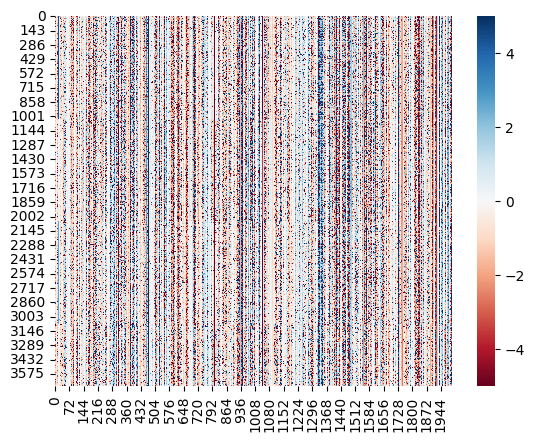

In [23]:
sns.heatmap(alpha_ratio, cmap='RdBu')

In [35]:
sc.tl.leiden(adata)

In [67]:
clu5_cells = (adata.obs['leiden'] == '5')
np.sum(clu5_cells)

269

In [37]:
alpha_ratio_clu5 = alpha_ratio[clu5_cells]
alpha_ratio_clu5

tensor([[-0.0780,  0.1349,  0.1899,  ...,  0.7529, -0.2275, -0.2859],
        [-0.1103,  0.3208, -0.1935,  ..., -0.6014, -0.5351, -0.2860],
        [-0.2518,  1.8937, -0.4120,  ...,  0.7529, -0.5351, -0.2859],
        ...,
        [-0.2012,  0.1101,  0.1887,  ...,  1.7078, -0.4854,  0.0289],
        [-0.1673,  0.0725,  0.3297,  ...,  2.8593, -0.3515,  0.0296],
        [-0.1404,  0.0735,  1.8416,  ...,  1.5077, -0.5019,  0.0283]])

In [42]:
arc5_mean = torch.mean(alpha_ratio_clu5, 0)
arc5_mean

tensor([-0.1977,  0.0967,  0.2594,  ...,  0.4889, -0.3782,  0.3184])

In [43]:
ar_mean = torch.mean(alpha_ratio, 0)
ar_mean

tensor([-0.1931,  0.0660,  0.1464,  ..., -0.0131, -0.3912,  0.3356])

<AxesSubplot: >

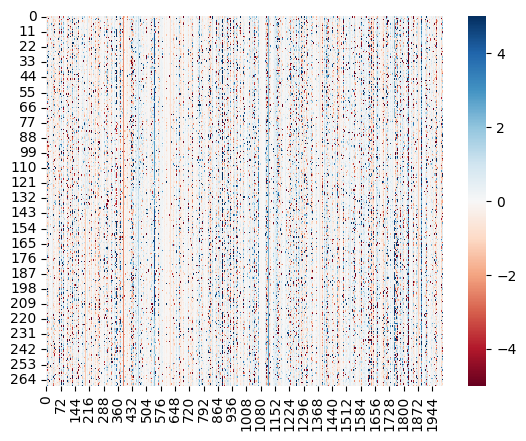

In [38]:
sns.heatmap(alpha_ratio_clu5, cmap='RdBu')

In [58]:
import pandas as pd

<AxesSubplot: xlabel='x', ylabel='y'>

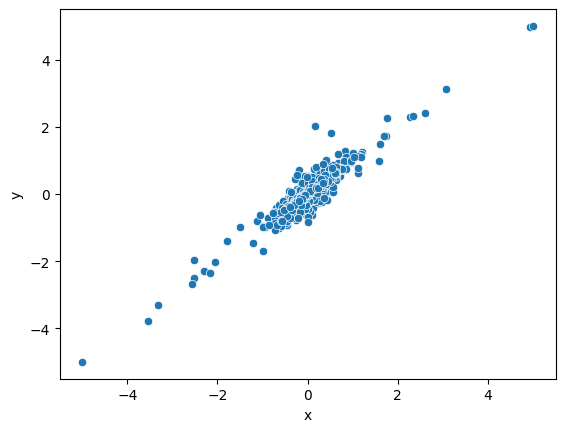

In [60]:
sns.scatterplot(
    pd.DataFrame(torch.vstack((ar_mean, arc5_mean), ).numpy().T, columns=['x', 'y']),
    x='x',
    y='y',
)

In [31]:
tf_weights = trainer.model.decoder.fcTF.ML0.weight.data.cpu().numpy()

<AxesSubplot: >

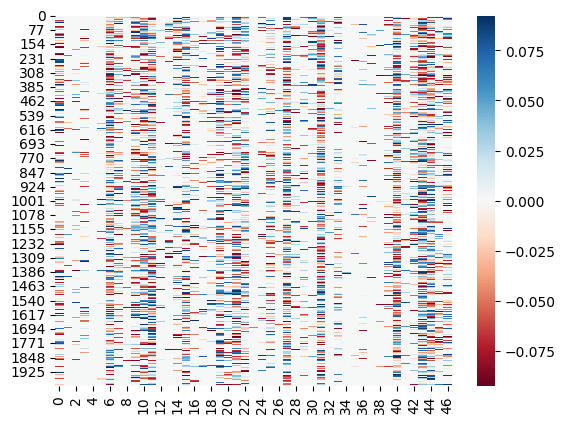

In [34]:
sns.heatmap(tf_weights * mask, cmap='RdBu')

In [45]:
adata.var['pred_gamma']

SNTG1      0.703386
SNHG6      0.688030
NCOA2      0.684067
SBSPON     0.675457
UBE2W      0.703743
             ...   
TMEM27     0.675949
UTY        0.704202
DDX3Y      0.682828
EIF2S3Y    0.695187
ERDR1      0.689043
Name: pred_gamma, Length: 2000, dtype: float32

In [61]:
adata.var['pred_gamma'].values.shape

(2000,)

In [58]:
adata.X.shape

(3696, 2000)

In [64]:
alpha = torch.nn.Softplus()( torch.Tensor(adata.uns['alpha_latent'] + adata.uns['alpha_TF'])).detach().numpy()
gamma_y = adata.X.multiply(adata.var['pred_gamma'].values).toarray() # 假设 y 是 adata.X
diff = alpha - gamma_y
diff

array([[0.67635435, 0.69378835, 0.6986691 , ..., 0.7135555 , 0.679235  ,
        0.69625765],
       [0.6819307 , 0.46095026, 0.7046712 , ..., 0.722136  , 0.6889856 ,
        0.69622755],
       [0.6816849 , 0.68304116, 0.68701583, ..., 0.7040536 , 0.6889307 ,
        0.69629395],
       ...,
       [0.68780655, 0.6979691 , 0.70564556, ..., 0.7136389 , 0.69018304,
        0.6906396 ],
       [0.700236  , 0.68634295, 0.51699954, ..., 0.51331306, 0.493264  ,
        0.69077796],
       [0.6860199 , 0.6836951 , 0.7079187 , ..., 0.720121  , 0.67832077,
        0.69073355]], dtype=float32)

In [72]:
diff[adata.obs['leiden']=='5'].mean()

0.6284016

In [73]:
gene_diffs = diff[adata.obs['leiden']=='5'].mean(0)
top_neg_genes = adata.var_names[np.argsort(gene_diffs)[:10]]
print("5区反向拉拽力最强的基因:", top_neg_genes)

5区反向拉拽力最强的基因: Index(['RPS19', 'RPS4X', 'RPL36A', 'RPS8', 'RPLP0', 'RPL32', 'RPL12', 'RPS2',
       'H3F3B', 'SPP1'],
      dtype='object')


导致 5 区反转的关键基因: Index(['RPS4X', 'RPL32', 'RPS19', 'RPS2', 'RPLP0'], dtype='object')


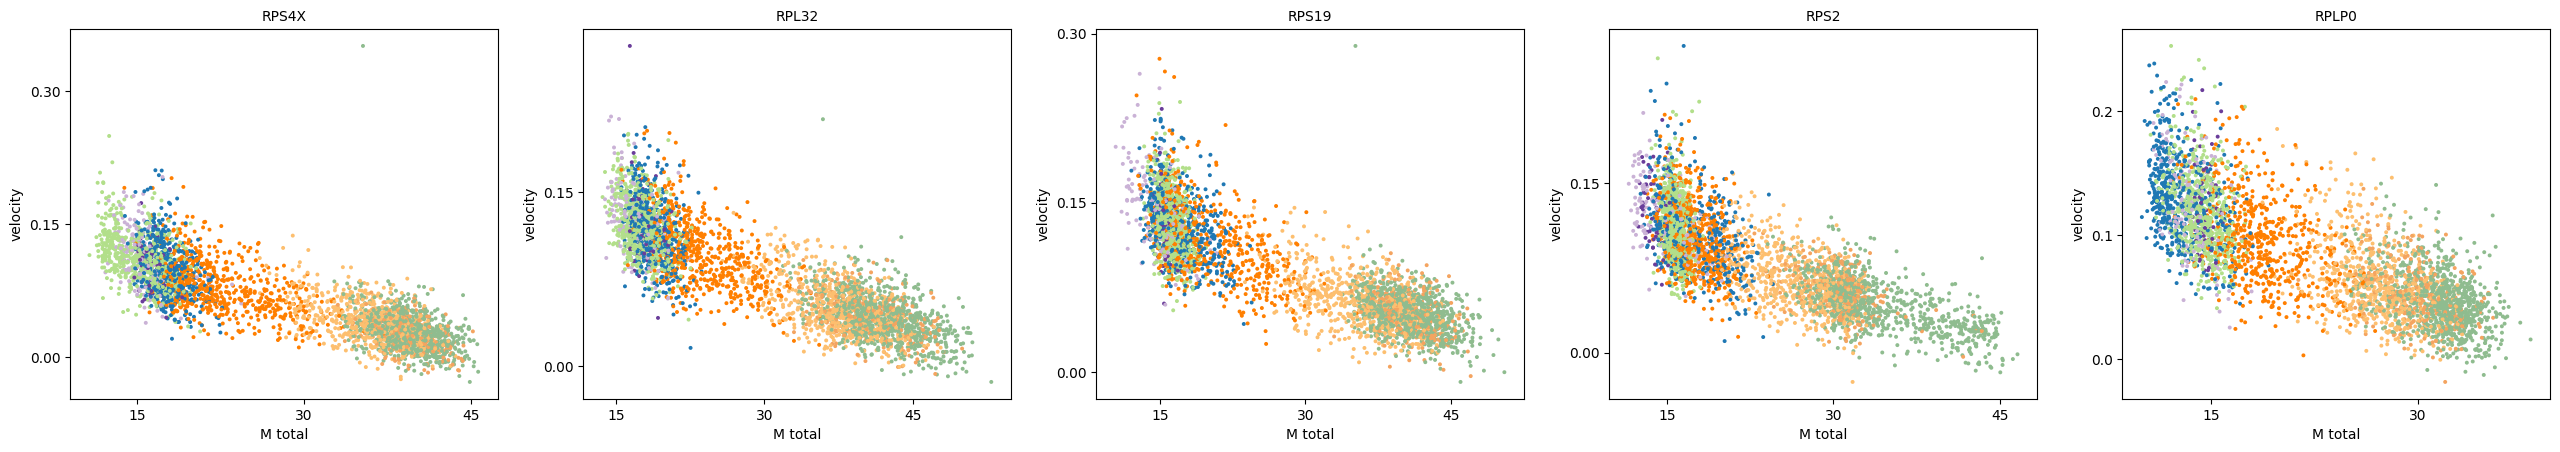

In [112]:
# 计算每个基因在 5 区的平均速度
gene_v = adata[adata.obs['leiden']=='5'].layers['velocity'].mean(0)
# 找出速度最负的前 5 个基因
bad_genes = adata.var_names[np.argsort(gene_v)[:5]]
print(f"导致 5 区反转的关键基因: {bad_genes}")

# 为这些基因画相图
import scvelo as scv
scv.pl.scatter(adata, x='M_total', y='velocity', var_names=bad_genes, color='clusters')

computing velocity graph (using 1/192 cores)
    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


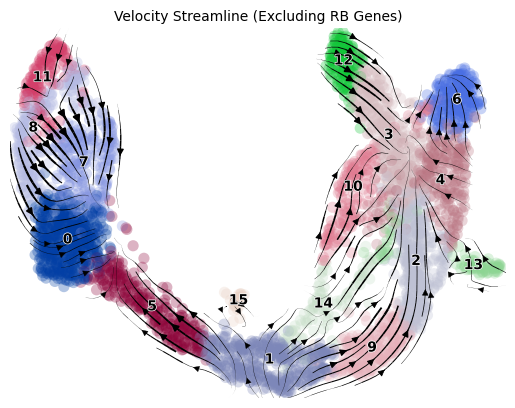

In [19]:
rb_genes = adata.var_names.str.startswith(('RPL', 'RPS'))
scv.tl.velocity_graph(adata, gene_subset=[g for g in adata.var_names if g not in rb_genes])
scv.tl.velocity_embedding(adata, basis='umap', vkey='velocity')
scv.pl.velocity_embedding_stream(adata, basis='umap', color='leiden', title='Velocity Streamline (Excluding RB Genes)')

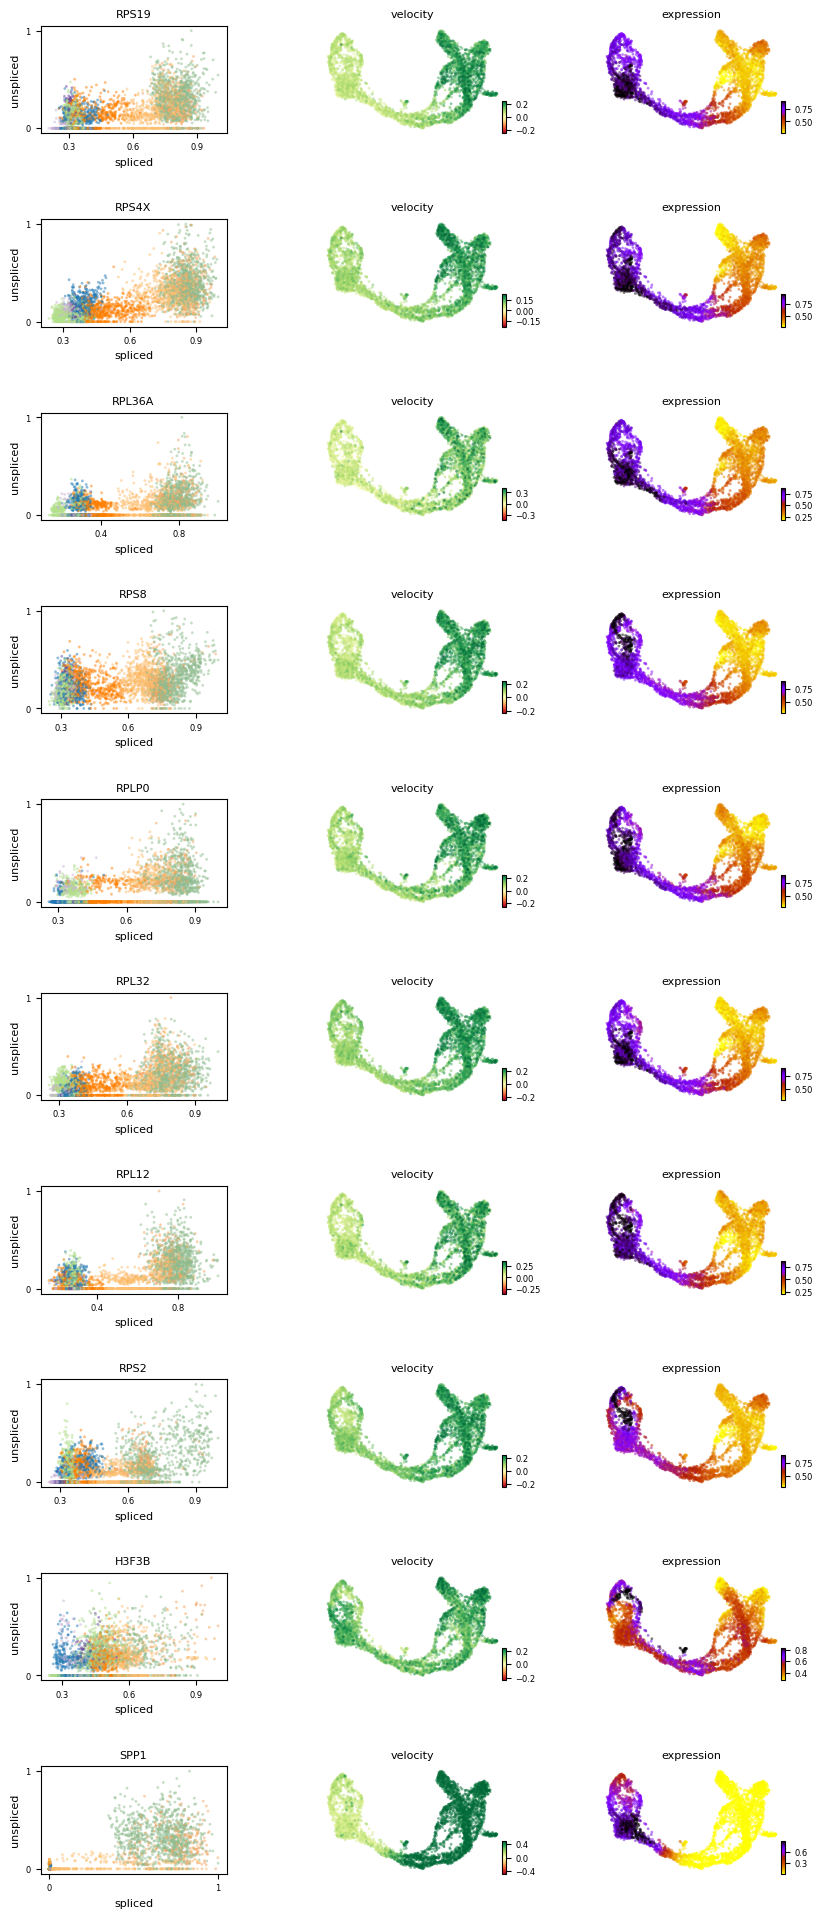

In [74]:
scv.pl.velocity(adata, var_names=['RPS19', 'RPS4X', 'RPL36A', 'RPS8', 'RPLP0', 'RPL32', 'RPL12', 'RPS2',
       'H3F3B', 'SPP1'])

In [40]:
adata.obs['velocity_pseudotime']

index
AAACCTGAGAGGGATA    0.623268
AAACCTGAGCCTTGAT    0.755845
AAACCTGAGGCAATTA    0.616153
AAACCTGCATCATCCC    0.034074
AAACCTGGTAAGTGGC    0.673933
                      ...   
TTTGTCAAGTGACATA    0.630611
TTTGTCAAGTGTGGCA    0.715925
TTTGTCAGTTGTTTGG    0.803742
TTTGTCATCGAATGCT    0.580122
TTTGTCATCTGTTTGT    0.594476
Name: velocity_pseudotime, Length: 3696, dtype: float64

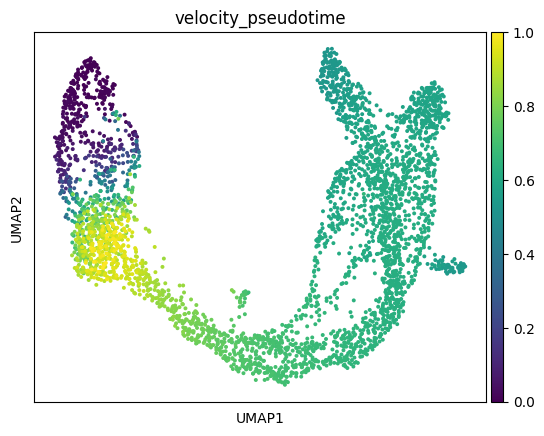

In [36]:
sc.pl.umap(adata, color='velocity_pseudotime')

In [11]:
with torch.no_grad():
    # 提取 5 区细胞的索引
    idx_5 = np.where(adata.obs['leiden'] == '5')[0]
    # 手动计算 5 区的平均速度符号
    # v = scale1 * (alpha - gamma * y)
    v_5 = adata.layers['velocity'][idx_5]
    pos_ratio = np.sum(v_5 > 0) / v_5.size
    print(f"5区基因速度为正的比例: {pos_ratio:.2%}")

5区基因速度为正的比例: 99.96%


In [104]:
adata.obs['clusters'] = adata.obs['clusters'].astype('category')

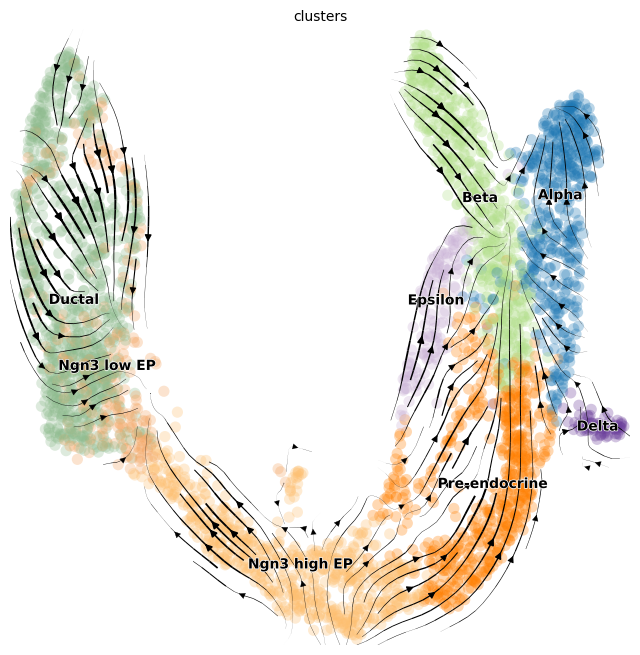

In [109]:
fig04 = plt.figure(figsize=(8, 8))
ax1 = fig04.subplots(1, 1, )
# scv.pl.scatter(adata, basis='umap', color='clusters', ax=ax1, show=False)

scv.pl.velocity_embedding_stream(adata, basis='umap', 
                                 color='clusters', 
                                 ax=ax1, 
                                 show=False)
fig04.savefig('figures/fig04.pdf', dpi=300)

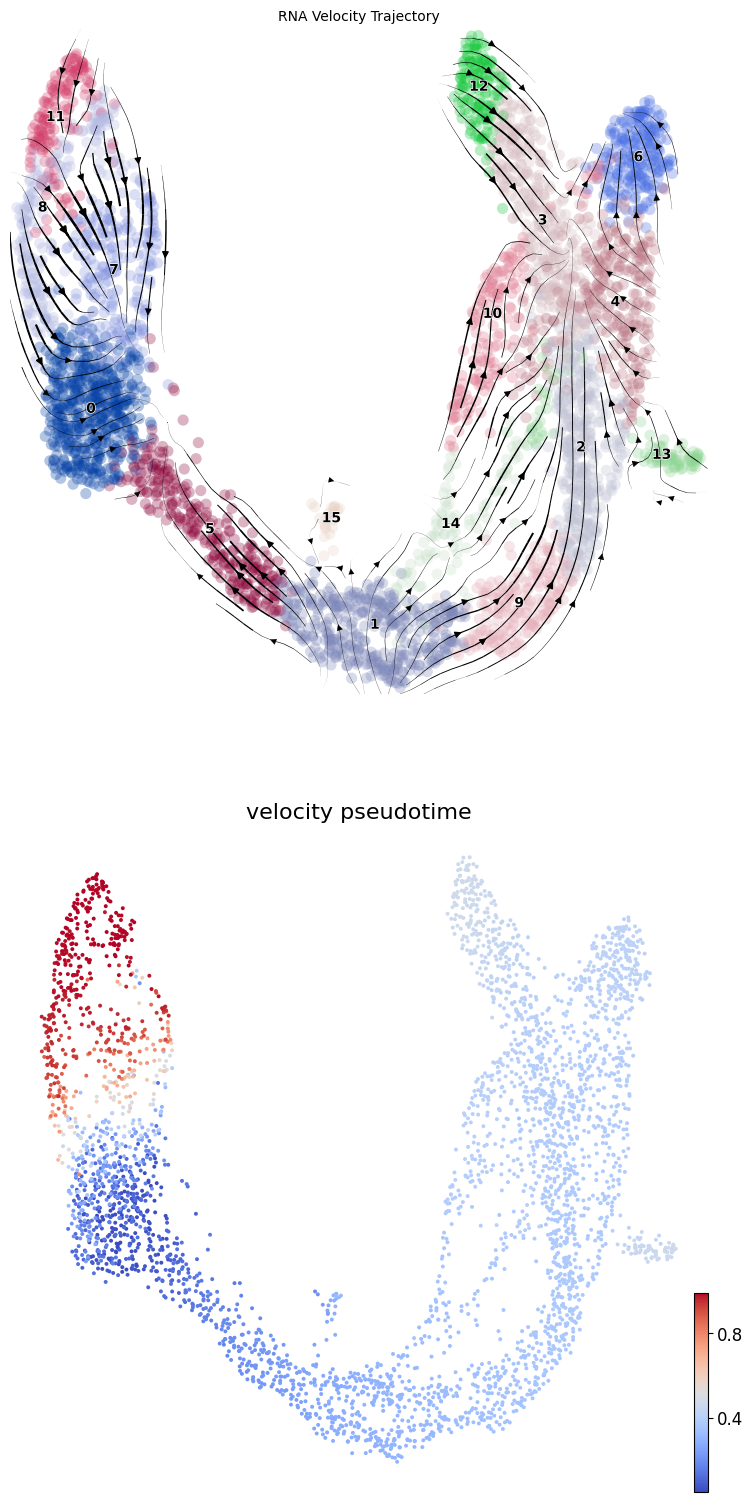

In [165]:
fig01 = plt.figure(figsize=(9, 19))
(ax1, ax2) = fig01.subplots(2, 1, )

# 绘制RNA速度轨迹
scv.pl.velocity_embedding_stream(adata, basis='umap', 
                                 color='leiden', 
                                 title='RNA Velocity Trajectory',
                                 dpi=100, ax=ax1, show=False)

# 结合伪时间
scv.pl.scatter(adata, color='velocity_pseudotime', 
               fontsize=16, color_map='coolwarm', 
               perc=[2, 98], ax=ax2, show=False)

fig01.savefig('figures/fig01.pdf', dpi=300)
plt.show()

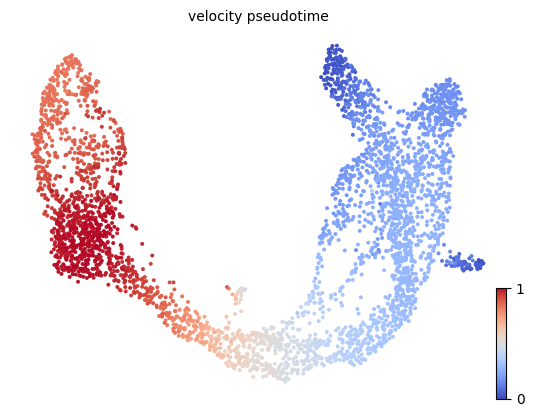

In [31]:
root_idx = adata.obs_names[adata.obs['leiden'] == '11' ]
scv.tl.velocity_pseudotime(
    adata, 
    # groupby='leiden', 
    # groups='11'
    root_key=tuple(root_idx)
)

# 观察伪时间图是否反转（5 区变蓝/白，0 区变红）
scv.pl.scatter(adata, color='velocity_pseudotime', color_map='coolwarm')

recovering dynamics (using 1/192 cores)
    finished (0:07:31) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


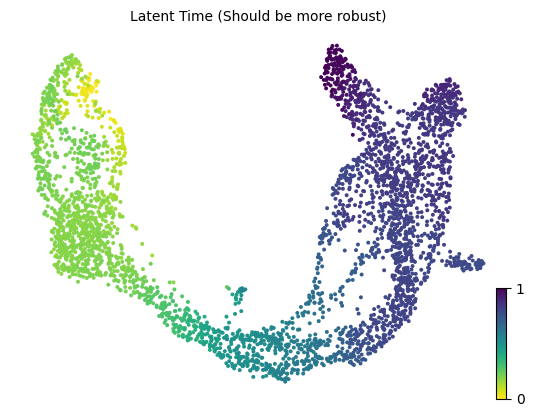

In [33]:
scv.tl.recover_dynamics(adata)
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', title='Latent Time (Should be more robust)')

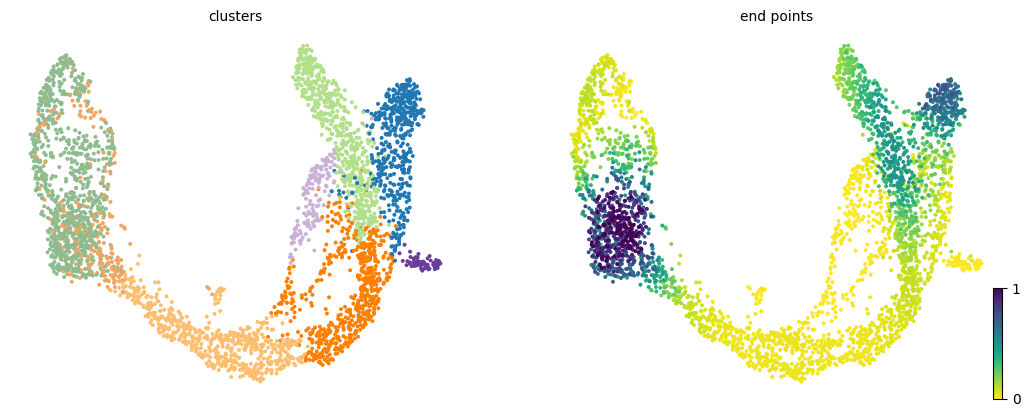

In [37]:
scv.pl.scatter(adata, color=['clusters', 'end_points'], basis='umap')

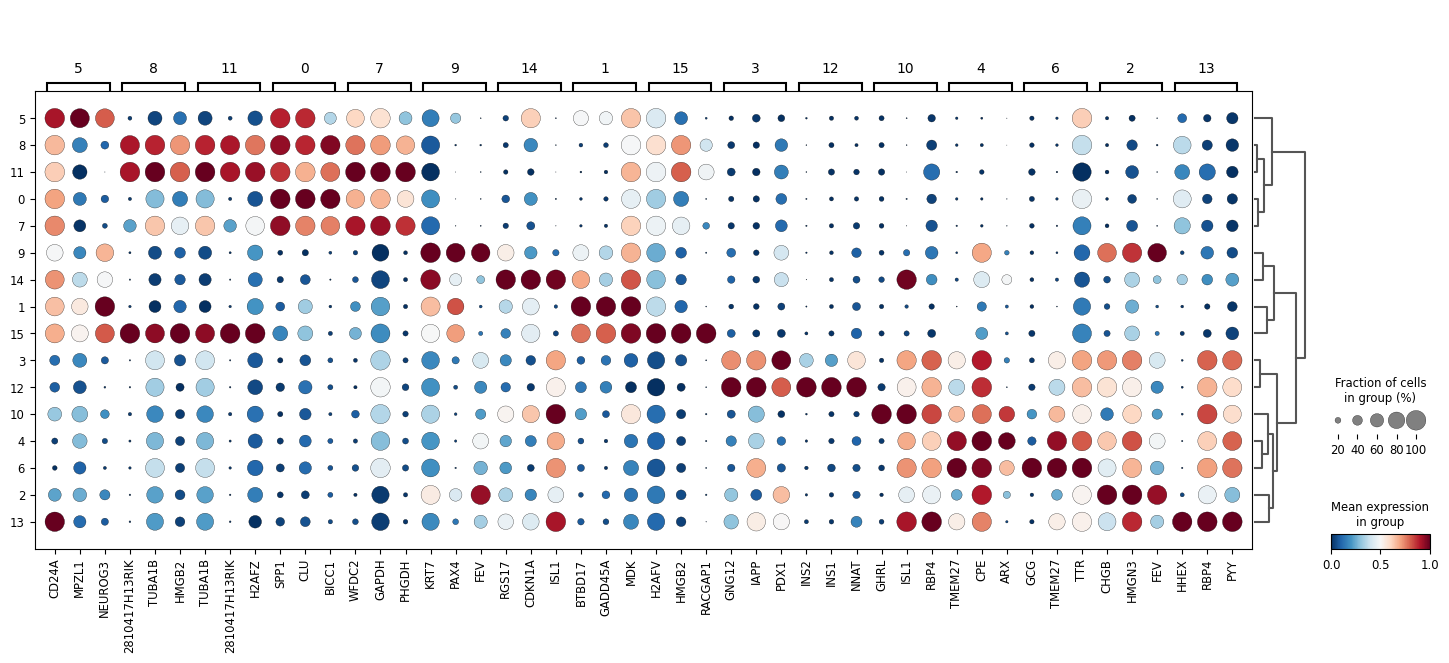

In [50]:
sc.tl.dendrogram(adata, groupby='leiden')
if 'rank_genes_groups' not in adata.uns:
    # 进行差异表达分析
    sc.tl.rank_genes_groups(adata, groupby='leiden', 
                           method='wilcoxon', 
                           use_raw=False)

fig02 = plt.figure(figsize=(18, 7))
ax1 = fig02.subplots(1, 1, )
sc.pl.rank_genes_groups_dotplot(adata, n_genes=3, groupby='leiden', standard_scale='var', cmap='RdBu_r', ax=ax1)
# ax1.set_title('DE genes of leiden groups')

fig02.savefig('figures/fig02.pdf', dpi=300)
plt.show()

In [14]:
trainer.model.eval()

InterVELO(
  (z_encoder): TNODE(
    (lode_func): LatentODEfunc(
      (elu): ELU(alpha=1.0)
      (fc1): Linear(in_features=20, out_features=25, bias=True)
      (fc2): Linear(in_features=25, out_features=20, bias=True)
    )
    (encoder): Encoder(
      (fc): Sequential(
        (L1): Linear(in_features=4000, out_features=128, bias=True)
        (D1): Dropout(p=0.1, inplace=False)
        (A1): ReLU()
      )
      (fc2): Linear(in_features=128, out_features=40, bias=True)
      (fc3): Sequential(
        (L2): Linear(in_features=128, out_features=1, bias=True)
        (D2): Dropout(p=0.1, inplace=False)
      )
    )
    (decoder): Decoder1(
      (fc): Sequential(
        (L1): Linear(in_features=20, out_features=128, bias=True)
        (A1): ReLU()
      )
      (fc2): Linear(in_features=128, out_features=4000, bias=True)
    )
  )
  (decoder): VELODecoder(
    (fcTF): Sequential(
      (ML0): MaskedLinear(in_features=47, out_features=2000, bias=True)
      (D0): Dropout(p=0.0, i

## Biosignificance

In [61]:
import seaborn as sns
import pandas as pd

In [35]:
adata.var_names

Index(['Sntg1', 'Snhg6', 'Ncoa2', 'Sbspon', 'Ube2w', 'Mcm3', 'Fam135a',
       'Adgrb3', 'Tmem131', 'Tbc1d8',
       ...
       'Sh3kbp1', 'Map3k15', 'Rai2', 'Rbbp7', 'Ap1s2', 'Tmem27', 'Uty',
       'Ddx3y', 'Eif2s3y', 'Erdr1'],
      dtype='object', name='index', length=2000)

In [36]:
'Surf4' in adata.var_names

True

In [44]:
print(adata.X[1:5 , 1:5])

  (0, 0)	0.3327278
  (2, 2)	0.33360565
  (3, 0)	0.42472324


In [50]:
adata.layers

Layers with keys: spliced, unspliced, Ms, Mu, velocity

In [46]:
df_surf4 = pd.concat([pd.DataFrame(adata[:, ['Surf4']].X.toarray(), index=adata.obs_names, columns=['Surf4']), adata.obs['velocity_pseudotime']], axis=1)
df_surf4

Surf4  velocity_pseudotime
index                                          
AAACCTGAGAGGGATA  0.376143             0.852704
AAACCTGAGCCTTGAT  0.000000             0.159336
AAACCTGAGGCAATTA  0.000000             0.892232
AAACCTGCATCATCCC  0.257067             0.004447
AAACCTGGTAAGTGGC  0.372437             0.706381
...                    ...                  ...
TTTGTCAAGTGACATA  0.238349             0.820761
TTTGTCAAGTGTGGCA  0.284982             0.570385
TTTGTCAGTTGTTTGG  0.000000             0.158520
TTTGTCATCGAATGCT  0.219043             0.997027
TTTGTCATCTGTTTGT  0.000000             0.959156

[3696 rows x 2 columns]

<AxesSubplot:xlabel='velocity_pseudotime', ylabel='Surf4'>

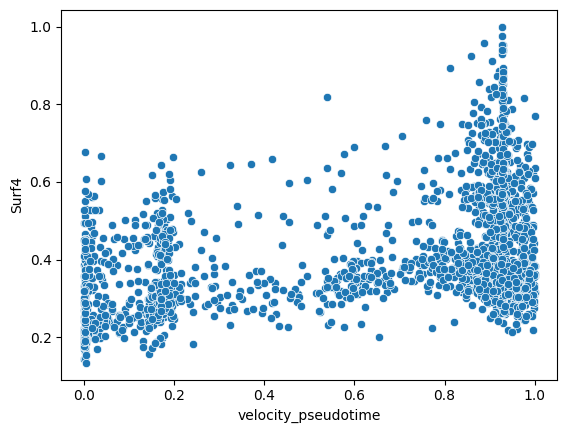

In [48]:
sns.scatterplot(data=df_surf4[df_surf4['Surf4'] > 0], x='velocity_pseudotime', y='Surf4')

<AxesSubplot:xlabel='velocity_pseudotime', ylabel='Ece1'>

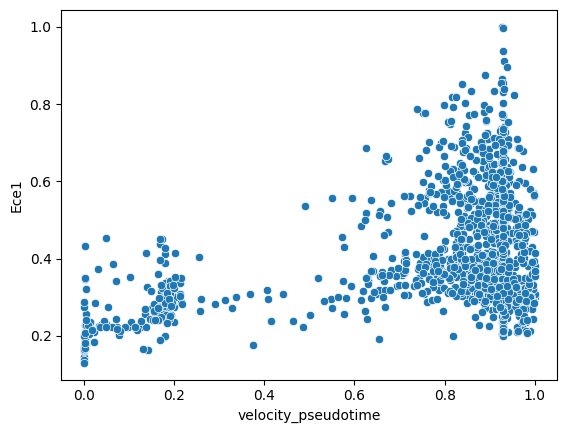

In [51]:
df_Ece1 = pd.concat([pd.DataFrame(adata[:, ['Ece1']].X.toarray(), index=adata.obs_names, columns=['Ece1']), adata.obs['velocity_pseudotime']], axis=1)

sns.scatterplot(data=df_Ece1[df_Ece1['Ece1'] > 0], x='velocity_pseudotime', y='Ece1')

<AxesSubplot:xlabel='velocity_pseudotime', ylabel='Litaf'>

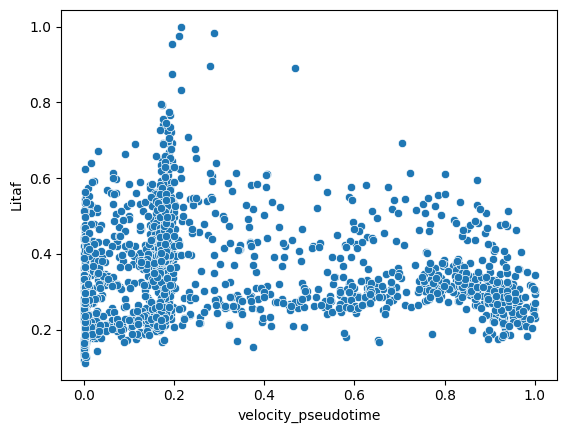

In [52]:
df_Litaf = pd.concat([pd.DataFrame(adata[:, ['Litaf']].X.toarray(), index=adata.obs_names, columns=['Litaf']), adata.obs['velocity_pseudotime']], axis=1)

sns.scatterplot(data=df_Litaf[df_Litaf['Litaf'] > 0], x='velocity_pseudotime', y='Litaf')

<AxesSubplot:xlabel='velocity_pseudotime', ylabel='Hmgb2'>

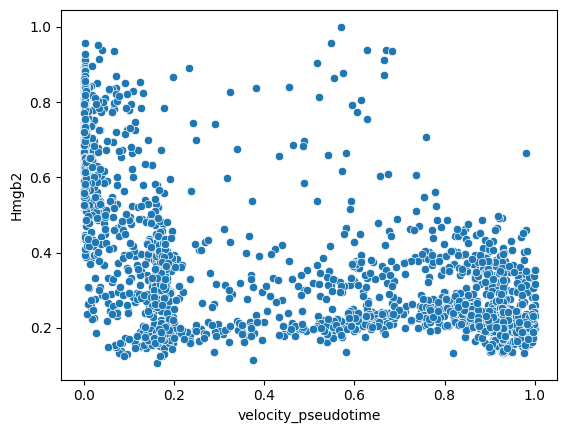

In [54]:
df_Hmgb2 = pd.concat([pd.DataFrame(adata[:, ['Hmgb2']].X.toarray(), index=adata.obs_names, columns=['Hmgb2']), adata.obs['velocity_pseudotime']], axis=1)

sns.scatterplot(data=df_Hmgb2[df_Hmgb2['Hmgb2'] > 0], x='velocity_pseudotime', y='Hmgb2')

In [59]:
adata.var_names

Index(['Sntg1', 'Snhg6', 'Ncoa2', 'Sbspon', 'Ube2w', 'Mcm3', 'Fam135a',
       'Adgrb3', 'Tmem131', 'Tbc1d8',
       ...
       'Sh3kbp1', 'Map3k15', 'Rai2', 'Rbbp7', 'Ap1s2', 'Tmem27', 'Uty',
       'Ddx3y', 'Eif2s3y', 'Erdr1'],
      dtype='object', name='index', length=2000)

## Nx

In [61]:
from importlib import reload
reload(scv.pl)

<module 'scvelo.pl' from '/home/qukungroup/syuqiao22/miniconda3/envs/P38C_TFvelo/lib/python3.8/site-packages/scvelo/pl.py'>

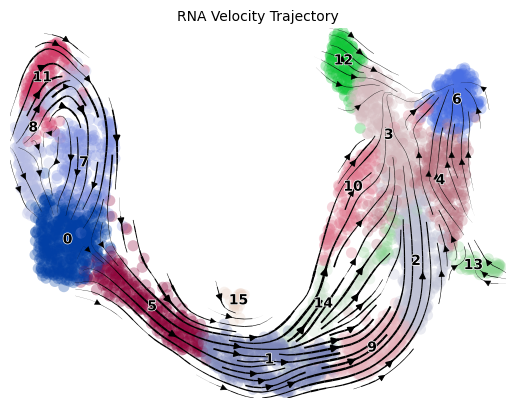

In [62]:
scv.pl.velocity_embedding_stream(adata, basis='umap', 
                                 color='leiden', 
                                 title='RNA Velocity Trajectory',
                                 dpi=100)

In [60]:
pseut = adata.obs['velocity_pseudotime']
pseut

index
AAACCTGAGAGGGATA    0.626672
AAACCTGAGCCTTGAT    0.749503
AAACCTGAGGCAATTA    0.619177
AAACCTGCATCATCCC    0.033518
AAACCTGGTAAGTGGC    0.677626
                      ...   
TTTGTCAAGTGACATA    0.633743
TTTGTCAAGTGTGGCA    0.719430
TTTGTCAGTTGTTTGG    0.806568
TTTGTCATCGAATGCT    0.582670
TTTGTCATCTGTTTGT    0.597961
Name: velocity_pseudotime, Length: 3696, dtype: float64

In [65]:
adata.X.toarray().shape

(3696, 2000)

In [70]:
adata.X.toarray()[:, 0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [166]:
from scipy.stats import spearmanr
correlations = []
for i, gene in enumerate(adata.var_names):
    corr, _ = spearmanr(adata.X[:, i].toarray().flatten(), pseut)
    correlations.append(corr)

# 排序并筛选
gene_corr_df = pd.DataFrame({'gene': adata.var_names, 'corr': correlations})
top_genes = gene_corr_df.reindex(gene_corr_df['corr'].abs().sort_values(ascending=False).index).head(20)
print(top_genes)

               gene      corr
628          TUBA1B  0.502621
196         NEUROG3 -0.470661
881            RBP4  0.451412
1080          ZFOS1 -0.445548
951           SPC25  0.439401
1294       MARCKSL1 -0.433438
1881  2810417H13RIK  0.425558
237            CD63 -0.424689
786           CLDN6 -0.409707
1569           IAPP  0.395998
679          SDF2L1  0.394787
587             PBK  0.391541
1065          PCSK2  0.388046
870           FKBP2  0.384162
341           AURKB  0.375209
1225          CDCA8  0.371072
795          CDKN1A -0.363292
298         SMARCD2 -0.361423
1637          MKI67  0.361165
1814          SPC24  0.360476


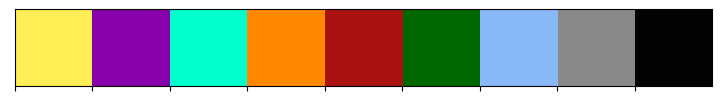

In [90]:
colourbar = ['#FFEE55', '#8800AA', '#00FFCC', '#FF8800', '#AA1111', '#006600', '#88B8F6', '#898989', 
             # '#FCFCFC'
             '#030304',
            ]
sns.palplot(colourbar)

In [167]:
top_genes_neg = top_genes[top_genes['corr'] < 0 ]
top_genes_pos = top_genes[top_genes['corr'] > 0 ]
top_genes_pos

gene      corr
628          TUBA1B  0.502621
881            RBP4  0.451412
951           SPC25  0.439401
1881  2810417H13RIK  0.425558
1569           IAPP  0.395998
679          SDF2L1  0.394787
587             PBK  0.391541
1065          PCSK2  0.388046
870           FKBP2  0.384162
341           AURKB  0.375209
1225          CDCA8  0.371072
1637          MKI67  0.361165
1814          SPC24  0.360476

In [118]:
pd.concat([top_genes_neg[:5], top_genes_pos[:5]])

gene      corr
628          TUBA1B -0.502621
881            RBP4 -0.451412
951           SPC25 -0.439401
1881  2810417H13RIK -0.425558
1569           IAPP -0.395998
196         NEUROG3  0.470661
1080          ZFOS1  0.445548
1294       MARCKSL1  0.433438
237            CD63  0.424689
786           CLDN6  0.409707

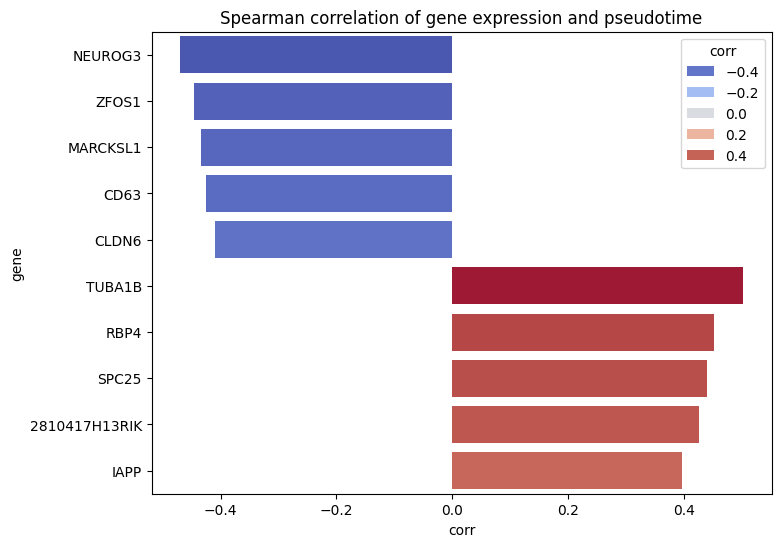

In [168]:
fig03 = plt.figure(figsize=(8, 6))
ax1 = fig03.subplots(1, 1, )
sns.barplot(pd.concat([top_genes_neg[:5], top_genes_pos[:5]]), x='corr', y='gene', palette='coolwarm', hue='corr', ax=ax1, )

ax1.set_title('Spearman correlation of gene expression and pseudotime')
fig03.savefig('figures/fig03.pdf', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1700x400 with 0 Axes>

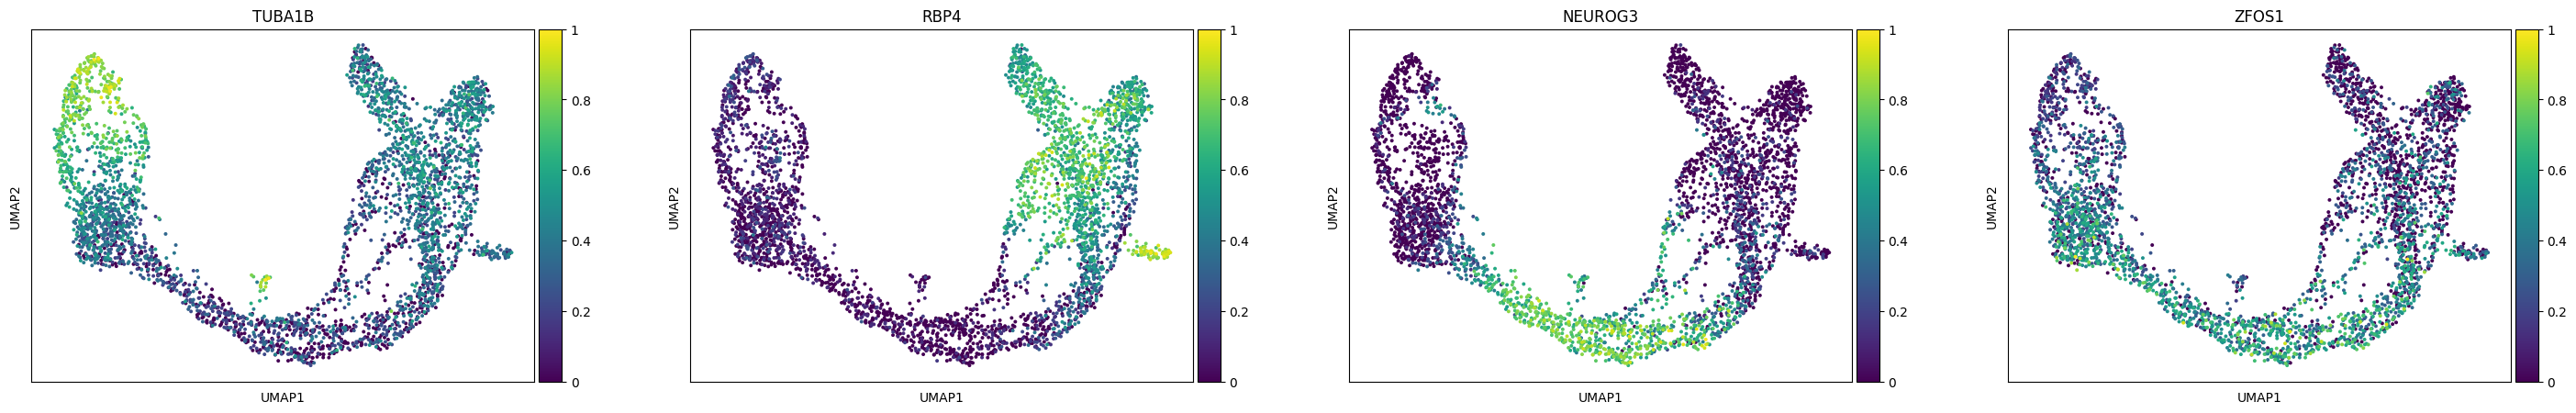

In [169]:
fig05 = plt.figure(figsize=(17, 4))
# axs = fig05.subplots(1, 4, )
# plt.subplots_adjust(wspace=0.4)
# sc.pl.scatter(adata, color='TUBA1B', basis='umap', ax=axs[0], show=False, )
# sc.pl.scatter(adata, color='RBP4', basis='umap', ax=axs[1], show=False, )  
# sc.pl.scatter(adata, color='NEUROG3', basis='umap', ax=axs[2], show=False, )
# sc.pl.scatter(adata, color='ZFOS1', basis='umap', ax=axs[3], show=False, )
# plt.tight_layout()
sc.pl.scatter(adata, color=['TUBA1B', 'RBP4', 'NEUROG3', 'ZFOS1'], basis='umap', show=False, )
fig05 = plt.gcf()
plt.tight_layout()
fig05.savefig('figures/fig05.pdf', dpi=300)
plt.show()

ranking velocity genes
    finished (0:00:02) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


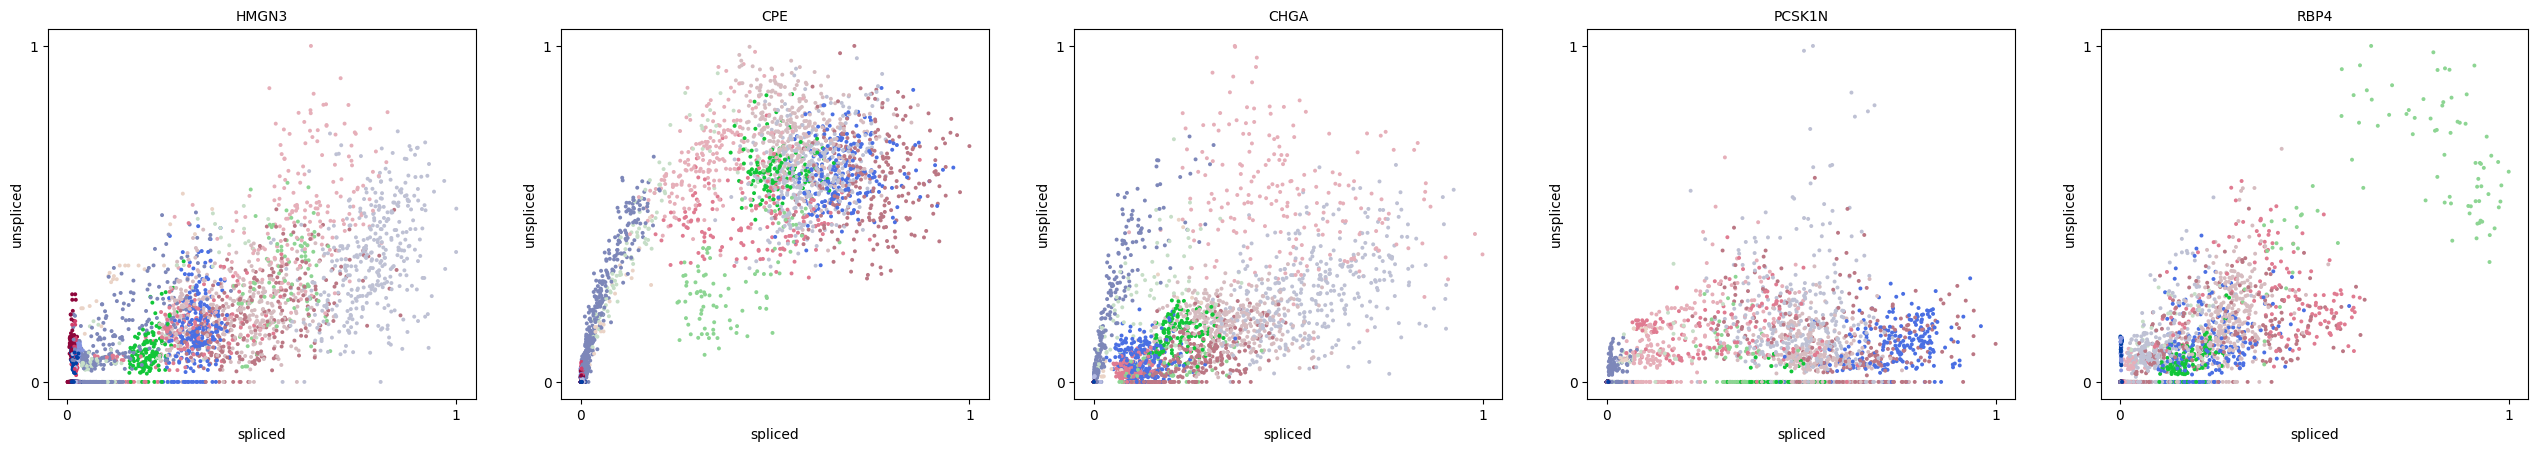

In [71]:
scv.tl.rank_velocity_genes(adata, groupby='leiden', n_genes=20)

# 3. 查看结果
scv.pl.scatter(adata, basis=adata.uns['rank_velocity_genes']['names']['5'][:5], color='leiden')

## ML0 weights

In [173]:
ml0_weights = trainer.model.decoder.fcTF.ML0.weight.cpu().detach().numpy()
ml0_weights.shape

(2000, 94)

In [178]:
TFs = [TF_name for TF_name in sorted(list(set(adata.varm['TFs'].flatten()))) if TF_name in adata.var_names]
weights_df = pd.DataFrame(ml0_weights, index=adata.var_names, columns=TFs + [TF + 'square' for TF in TFs])
weights_df

ATF3     AUTS2      BCOR     CCND1      CHD7     CLOCK     CREB1  \
SNTG1    0.002775  0.004150 -0.003946 -0.026990  0.025719  0.027537  0.024479   
SNHG6   -0.000004 -0.002810 -0.020666  0.025116 -0.010929  0.017504 -0.015387   
NCOA2   -0.017215  0.014831 -0.018683  0.015340  0.005869  0.011322 -0.000587   
SBSPON  -0.026364 -0.000198  0.017683 -0.019825 -0.000868  0.003988  0.003151   
UBE2W    0.028720  0.001087 -0.008573  0.015677  0.032066  0.021824 -0.016071   
...           ...       ...       ...       ...       ...       ...       ...   
TMEM27  -0.003690 -0.005620 -0.009391 -0.024676 -0.026068 -0.002306 -0.027704   
UTY      0.027503 -0.004112 -0.022887  0.000329  0.000585 -0.001859  0.009319   
DDX3Y   -0.030038 -0.031363 -0.013534  0.010537 -0.020590  0.003898 -0.015618   
EIF2S3Y  0.026110  0.015363  0.021801  0.015148  0.027075 -0.013693 -0.011414   
ERDR1    0.031867  0.027947  0.030596  0.004808 -0.021831 -0.012890  0.014770   

             CREM     DACH1      E2F1  ...  PDX1square  RCOR2square  \
SNTG1   -0.028489  0.022881 -0.027697  ...   -0.025601    -0.004675   
SNHG6   -0.028637 -0.009253  0.023622  ...    0.009764     0.013941   
NCOA2   -0.027574 -0.009425 -0.031066  ...    0.009832    -0.011827   
SBSPON  -0.005997  0.017898 -0.017070  ...    0.006264    -0.009754   
UBE2W    0.019641  0.031783 -0.011663  ...    0.002779     0.019662   
...           ...       ...       ...  ...         ...          ...   
TMEM27   0.022758  0.024844 -0.027923  ...   -0.006080    -0.009371   
UTY      0.020977 -0.006250 -0.013503  ...    0.005184    -0.007241   
DDX3Y    0.026108  0.001235 -0.025547  ...    0.025078    -0.015727   
EIF2S3Y -0.026264 -0.015718 -0.010062  ...   -0.016582    -0.022000   
ERDR1    0.005247  0.026213 -0.006368  ...    0.022001    -0.024993   

         RCOR3square  RESTsquare  SMC4square  SOX9square  STAT3square  \
SNTG1      -0.028955   -0.009245   -0.017050    0.000090    -0.002412   
SNHG6      -0.014248    0.010650   -0.022166   -0.000365     0.003553   
NCOA2       0.007044    0.003726    0.006147   -0.000683    -0.027043   
SBSPON      0.011815   -0.017534    0.000819    0.023664     0.020760   
UBE2W      -0.011801   -0.013476    0.003832    0.018243    -0.029705   
...              ...         ...         ...         ...          ...   
TMEM27     -0.019987    0.016202   -0.030758   -0.003433    -0.014760   
UTY        -0.029108    0.007830    0.028915    0.001642    -0.018035   
DDX3Y      -0.002894    0.021796    0.009173    0.015686     0.024248   
EIF2S3Y    -0.015494    0.016480    0.005660   -0.017420     0.019971   
ERDR1      -0.021396    0.019023    0.003599   -0.001892     0.022923   

         USF2square  VDRsquare  ZEB1square  
SNTG1     -0.029777  -0.011488   -0.024362  
SNHG6      0.011871  -0.026734   -0.023042  
NCOA2     -0.015025   0.019109   -0.001734  
SBSPON    -0.004994  -0.030070   -0.018664  
UBE2W      0.018827  -0.000878    0.024406  
...             ...        ...         ...  
TMEM27    -0.008954   0.014968    0.009931  
UTY       -0.011840   0.002426   -0.025920  
DDX3Y      0.021361   0.028381   -0.027314  
EIF2S3Y   -0.030053   0.020540    0.020505  
ERDR1      0.024392   0.014288   -0.014911  

[2000 rows x 94 columns]

<AxesSubplot: >

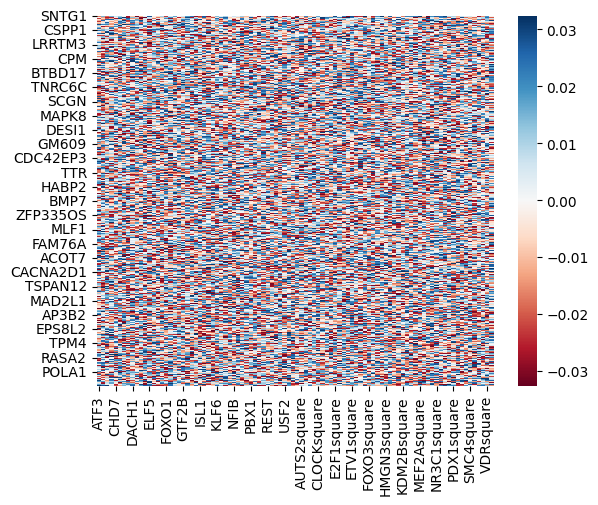

In [179]:
sns.heatmap(weights_df, cmap='RdBu')

In [204]:
gene_name = 'RBP4'
if gene_name in adata.var_names:
    gene_idx = np.where(adata.var_names == gene_name)[0][0]
    rbp4_regulators = pd.DataFrame({
        'TF': TFs + [TF + 'square' for TF in TFs],
        'Weight': ml0_weights[gene_idx, :]
    }).sort_values('Weight', ascending=False)
    
    print(f"Top TFs promoting {gene_name}:")
    print(rbp4_regulators.head(5))

Top TFs promoting RBP4:
             TF    Weight
42         SOX9  0.031387
64  FOXO3square  0.030756
31         MXI1  0.030609
78   MXI1square  0.030484
8         DACH1  0.029129


In [205]:
pd.concat([rbp4_regulators.head(5), rbp4_regulators.iloc[-5:]])

TF    Weight
42         SOX9  0.031387
64  FOXO3square  0.030756
31         MXI1  0.030609
78   MXI1square  0.030484
8         DACH1  0.029129
70  IGF1Rsquare -0.027335
38        RCOR2 -0.030749
76  MEF2Asquare -0.031355
1         AUTS2 -0.031687
20        GTF2B -0.031863

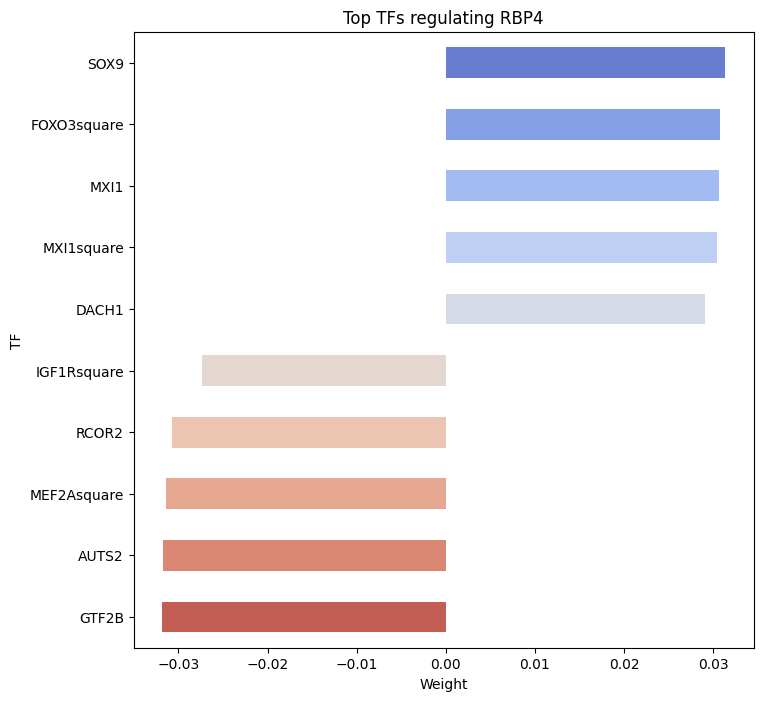

In [211]:
fig06 = plt.figure(figsize=(8, 8))
ax1 = fig06.subplots(1, 1, )
sns.barplot(pd.concat([rbp4_regulators.head(5), rbp4_regulators.iloc[-5:]]), x='Weight', y='TF', palette='coolwarm', ax=ax1, width=0.5)
ax1.set_title('Top TFs regulating RBP4')
fig06.savefig('figures/fig06.pdf', dpi=300, bbox_inches='tight')

In [22]:
adata = sc.read_h5ad('TFvelo_revealing/Myvelo.h5ad')